# Exploratory analysis of GSC metabolomics data
Data collected and provided by Olga

### Cleanup data

In [143]:
# Import libraries
import pandas as pd
import numpy as np
from collections import Counter

In [144]:
# Import the metabolomics data
metabolomics_df = pd.read_csv('C:/research/raw_data/20200207_SU2C_All_Knowns.csv', index_col=0)
metabolomics_df.head()

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
1,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,1.0,0.648389,0.233167,...,0.031392,0.083978,1.407985,23.773639,0.055788,27823.74426,18542.49087,0.001257,4.165198,7.158272
2,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,2.0,0.607384,0.160450,...,0.033101,0.090519,1.306536,27.819868,0.060646,26961.89141,25807.97566,0.001185,4.298604,7.028919
3,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,3.0,0.677430,0.161100,...,0.039041,0.130953,1.308885,28.465713,0.068040,24184.86136,19483.41231,0.001135,4.000341,8.386796
4,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,4.0,0.658178,0.147507,...,0.032998,0.082612,1.355951,28.223934,0.041304,25654.80883,21779.36667,0.001220,4.327418,6.882724
5,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,5.0,0.552922,0.179677,...,0.037922,0.074435,1.106163,23.120153,0.055203,28370.42718,21526.05841,0.001093,3.884993,8.677013


In [145]:
# Correct mistakes in the original dataframe
# ('X20160316', np.int64(1), 'G571', 'Normoxia') was a mistake, the date for this should be 'X20160406'
metabolomics_df.loc[(metabolomics_df['DateProcessed'] == 'X20160316') &
                    (metabolomics_df['Trial'] == 1) &
                    (metabolomics_df['CellLine'] == 'G571') &
                    (metabolomics_df['Oxygen'] == 'Normoxia'), 'DateProcessed'] = 'X20160406'
                
# ('X20161124', np.int64(1), 'BT301', 'Normoxia') only has 22 rows because there are only 5 replicates for both "Cells" and "Secreted" metabolites

# ('X20161018', np.int64(2), 'G620', 'Normoxia') only has 21 rows because there are only 4 replicates for "Cells" and only 5 replicates for "MediaControl"

# ('X20161018', np.int64(2), 'G564', 'Normoxia') only has 11 rows because there are only 5 replicates for "Cells" and only 6 replicates for "Secreted", no controls

# ('X20160316', np.int64(1), 'G729', 'Normoxia') has 34 rows because there are 12 replicates each for "Cells" and "Secreted"

# There are 6 dataframes with 14 rows each. These data are from the Weiss lab and their cell lines begin with "BT"
# ('X20170203', np.int64(1), 'BT147', 'Normoxia')
# ('X20170330', np.int64(1), 'BT169', 'Normoxia')
# ('X20170330', np.int64(1), 'BT189', 'Normoxia')
# ('X20170330', np.int64(1), 'BT301', 'Normoxia')
# ('X20170330', np.int64(1), 'BT69', 'Normoxia')
# ('X20170330', np.int64(1), 'BT94', 'Normoxia')

# There are 7 dataframes with 15 rows each. These data are from the Weiss lab and their cell lines begin with "BT"
# ('X20170203', np.int64(1), 'BT48', 'Normoxia')
# ('X20170203', np.int64(1), 'BT50', 'Normoxia')
# ('X20170203', np.int64(1), 'BT73', 'Normoxia')
# ('X20170203', np.int64(1), 'BT75', 'Normoxia')
# ('X20170203', np.int64(1), 'BT89', 'Normoxia')
# ('X20170330', np.int64(1), 'BT248', 'Normoxia')
# ('X20170525', np.int64(1), 'BT238', 'Normoxia')

In [146]:
# How many unique cell lines are here? 68
metabolomics_df['CellLine'].nunique()

68

In [147]:
# For simplicity, only look at data of cell lines from the Dirks lab for now

# Ensure the cell line column is string type
metabolomics_df['CellLine'] = metabolomics_df['CellLine'].astype('string')

# Remove all cell lines starting with "HF" in the full dataframe, these are human fetal
metabolomics_df = metabolomics_df[~metabolomics_df['CellLine'].str.startswith('HF')]

# Keep only rows where the Lab column is "Dirks"
metabolomics_df = metabolomics_df[metabolomics_df['Lab'] == 'Dirks']

# Remove rows where SampleType is "Cells" and TotalRNA is NaN
# These samples cannot be normalized to RNA amount
metabolomics_df = metabolomics_df[~((metabolomics_df['SampleType'] == 'Cells') & (metabolomics_df['TotalRNA'].isna()))]

# How many unique cell lines are here? Now 34
metabolomics_df['CellLine'].nunique()

34

In [148]:
# Subset the dataframe for a specific cell line, e.g., 'G523'
G523_df = metabolomics_df[metabolomics_df['CellLine'] == 'G523']
G523_df

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
163,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,1.0,0.267561,0.031166,...,0.037939,0.472435,0.230827,0.704831,0.239954,7.312621,9.261954,0.000102,0.061448,4.121885
164,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,2.0,0.389552,0.043990,...,0.030166,0.194152,0.100240,1.213483,0.370319,11.247858,9.712298,0.000094,0.029010,4.096100
165,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,3.0,0.261106,0.033545,...,0.023404,0.226679,0.092935,0.699387,0.223355,9.859366,8.602156,0.000090,0.029153,4.196879
166,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,4.0,0.211518,0.029799,...,0.029781,0.208066,0.096608,0.239352,0.261994,9.185934,5.689928,0.000105,0.022313,4.170834
167,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,5.0,0.149310,0.042557,...,0.024108,0.219265,0.111523,0.280174,0.261121,9.785174,8.193086,0.000119,0.022712,4.399674
168,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,6.0,0.126174,0.034243,...,0.024884,0.160767,0.077155,0.283596,0.170843,7.672585,8.656908,0.000098,0.020306,3.888903
169,X20160621,NaN,1,Dirks,G523,MediaControl,Normoxia,1.0,0.294595,0.067076,...,0.028304,0.036006,0.097526,0.395041,0.403458,12.822295,10.281107,0.000657,0.106439,7.387533
170,X20160621,NaN,1,Dirks,G523,MediaControl,Normoxia,2.0,0.282187,0.048903,...,0.030559,0.126570,0.361052,0.911564,0.407024,17.448724,36.773607,0.000747,0.214067,8.240283
171,X20160621,NaN,1,Dirks,G523,MediaControl,Normoxia,3.0,0.206038,0.115745,...,0.028734,0.054968,0.144775,0.459707,0.432076,21.208568,35.470553,0.000728,0.144201,8.544129


In [149]:
# Check the datatypes of the columns in the original dataframe
print(metabolomics_df.dtypes)

DateProcessed                      object
TotalRNA                          float64
Trial                               int64
Lab                                object
CellLine                   string[python]
                                ...      
X3_Methyl_2_Oxopentoate           float64
X4_Methyl_2_Oxopentoate           float64
X5_Hydroxy_Trp                    float64
Xanthine                          float64
Xylulose_5P                       float64
Length: 82, dtype: object


In [150]:
# Split the full dataframe into small dataframes based on unique combinations of DateProcessed, Trial, CellLine, and Oxygen
import numpy as np
from collections import Counter

# Split the G523 large dataframe into two dataframes
# Create a dictionary of dataframes
dfs_dict = {key: group for key, group in metabolomics_df.groupby(['DateProcessed', 'Trial', 'Lab', 'CellLine', 'Oxygen'])}
dfs_dict

print(list(dfs_dict.keys()))
print("The main df has been split into " + str(len(dfs_dict)) + " dataframes.")

# Example: access the dataframe for a specific combination
# subset_df = dfs_dict[('X20180717', np.int64(1), 'G809', 'Normoxia')]
# print(subset_df)

[('X20160316', np.int64(1), 'Dirks', 'G729', 'Normoxia'), ('X20160406', np.int64(1), 'Dirks', 'G571', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G549', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G566', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G583', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G620', 'Normoxia'), ('X20160621', np.int64(1), 'Dirks', 'G523', 'Normoxia'), ('X20160621', np.int64(1), 'Dirks', 'G564', 'Normoxia'), ('X20160916', np.int64(2), 'Dirks', 'G583', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G523', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G549', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G564', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G620', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G729', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'BT301', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'BT50', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'BT94', 'Normoxia'), ('X20161124', np.int64(1), 'D

In [61]:
# Iterate through the dictionary and print the number of rows in each dataframe
row_counts = {key: df.shape[0] for key, df in dfs_dict.items()}
print(row_counts)

# Count the frequency of each row count
count_freq = Counter(row_counts.values())
print(count_freq)
# Counter({24: 36, 23: 5, 34: 1, 18: 1, 11: 1, 21: 1, 22: 1})
# The dataframe with only 18 rows is missing Cells
# The dataframe with only 11 rows is missing Coating and MediaControl, all other dataframes can be used for intracellular metabolite analysis

{('X20160316', np.int64(1), 'Dirks', 'G729', 'Normoxia'): 34, ('X20160406', np.int64(1), 'Dirks', 'G571', 'Normoxia'): 18, ('X20160502', np.int64(1), 'Dirks', 'G549', 'Normoxia'): 23, ('X20160502', np.int64(1), 'Dirks', 'G566', 'Normoxia'): 24, ('X20160502', np.int64(1), 'Dirks', 'G583', 'Normoxia'): 24, ('X20160502', np.int64(1), 'Dirks', 'G620', 'Normoxia'): 24, ('X20160621', np.int64(1), 'Dirks', 'G523', 'Normoxia'): 24, ('X20160621', np.int64(1), 'Dirks', 'G564', 'Normoxia'): 23, ('X20160916', np.int64(2), 'Dirks', 'G583', 'Normoxia'): 24, ('X20161018', np.int64(2), 'Dirks', 'G523', 'Normoxia'): 24, ('X20161018', np.int64(2), 'Dirks', 'G549', 'Normoxia'): 23, ('X20161018', np.int64(2), 'Dirks', 'G564', 'Normoxia'): 11, ('X20161018', np.int64(2), 'Dirks', 'G620', 'Normoxia'): 21, ('X20161018', np.int64(2), 'Dirks', 'G729', 'Normoxia'): 24, ('X20161124', np.int64(1), 'Dirks', 'BT301', 'Normoxia'): 22, ('X20161124', np.int64(1), 'Dirks', 'BT50', 'Normoxia'): 24, ('X20161124', np.int64

In [62]:
# Given the number of rows, print the keys (i.e., the combinations) that have that number of rows
def print_keys_for_row_count(row_count):
    keys = [key for key, count in row_counts.items() if count == row_count]
    for key in keys:
        print(key)

print_keys_for_row_count(12)

In [63]:
# Pull specific dataframe from the dictionary 
dfs_dict[('X20160316', np.int64(1), 'Dirks', 'G729', 'Normoxia')]

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
1,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,1.0,0.648389,0.233167,...,0.031392,0.083978,1.407985,23.773639,0.055788,27823.744260,18542.490870,0.001257,4.165198,7.158272
2,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,2.0,0.607384,0.160450,...,0.033101,0.090519,1.306536,27.819868,0.060646,26961.891410,25807.975660,0.001185,4.298604,7.028919
3,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,3.0,0.677430,0.161100,...,0.039041,0.130953,1.308885,28.465713,0.068040,24184.861360,19483.412310,0.001135,4.000341,8.386796
4,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,4.0,0.658178,0.147507,...,0.032998,0.082612,1.355951,28.223934,0.041304,25654.808830,21779.366670,0.001220,4.327418,6.882724
5,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,5.0,0.552922,0.179677,...,0.037922,0.074435,1.106163,23.120153,0.055203,28370.427180,21526.058410,0.001093,3.884993,8.677013
6,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,6.0,0.571963,0.165721,...,0.041156,0.072914,1.164580,23.703608,0.070233,24100.436500,26821.829730,0.001116,3.669924,9.284897
7,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,7.0,0.796806,0.232587,...,0.037406,0.064332,1.128247,16.168259,0.119402,21949.179960,18623.542820,0.001098,3.184933,9.451866
8,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,8.0,0.791972,0.173989,...,0.039668,0.076015,0.980611,15.931988,0.064417,21194.106520,20341.938660,0.000993,2.845267,10.067808
9,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,9.0,0.721547,0.102578,...,0.037375,0.071462,1.068608,18.777159,0.040971,20260.540500,19921.617490,0.001088,3.388513,9.563010


In [64]:
keys_with_24_rows = [key for key, count in row_counts.items() if count == 24]
print("There are " + str(len(keys_with_24_rows)) + " dataframes with 24 rows each:")
print(keys_with_24_rows)


There are 36 dataframes with 24 rows each:
[('X20160502', np.int64(1), 'Dirks', 'G566', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G583', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G620', 'Normoxia'), ('X20160621', np.int64(1), 'Dirks', 'G523', 'Normoxia'), ('X20160916', np.int64(2), 'Dirks', 'G583', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G523', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G729', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'BT50', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'BT94', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'G477', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'G626', 'Normoxia'), ('X20170329', np.int64(1), 'Dirks', 'G607', 'Normoxia'), ('X20170329', np.int64(1), 'Dirks', 'G648', 'Normoxia'), ('X20170329', np.int64(1), 'Dirks', 'G691', 'Normoxia'), ('X20170329', np.int64(1), 'Dirks', 'G752', 'Normoxia'), ('X20170329', np.int64(2), 'Dirks', 'G683', 'Normoxia'), ('X20170710', np.int64(1), 'Dirks', 'G637', 

In [65]:
[key for key, count in row_counts.items() if count == 22]
dfs_dict[('X20161124', np.int64(1), 'Dirks', 'BT301', 'Normoxia')]

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
848,X20161124,NaN,1,Dirks,BT301,Coating,Normoxia,1.0,0.859862,0.009800,...,0.055259,0.063524,0.042121,0.621883,0.111859,8.288877,8.547306,0.000874,0.059781,5.240849
849,X20161124,NaN,1,Dirks,BT301,Coating,Normoxia,2.0,0.747545,0.008284,...,0.077154,0.073537,0.044705,0.665771,0.156543,9.039256,8.600095,0.000809,0.055001,5.085308
850,X20161124,NaN,1,Dirks,BT301,Coating,Normoxia,3.0,0.801929,0.006442,...,0.044702,0.076707,0.038626,0.614175,0.064182,7.672568,8.478413,0.000721,0.045103,5.070102
851,X20161124,NaN,1,Dirks,BT301,Coating,Normoxia,4.0,1.514332,0.007442,...,0.133913,0.121334,0.048148,0.846125,0.076465,14.682365,14.088903,0.001639,0.108822,10.121273
852,X20161124,NaN,1,Dirks,BT301,Coating,Normoxia,5.0,0.649396,0.008254,...,0.047335,0.136812,0.051603,0.684657,0.095019,10.032885,8.280833,0.000750,0.059216,5.993501
853,X20161124,NaN,1,Dirks,BT301,Coating,Normoxia,6.0,0.662449,0.007612,...,0.043983,0.086973,0.031142,0.641622,0.093509,7.022180,8.413735,0.000684,0.049504,6.056479
871,X20161124,22.880,1,Dirks,BT301,Cells,Normoxia,1.0,0.589461,3.750000,...,0.219147,0.096139,0.042495,27.003515,inf,25.371181,25.461809,0.000471,0.018100,5.978129
872,X20161124,23.970,1,Dirks,BT301,Cells,Normoxia,2.0,0.606827,0.106450,...,0.651670,0.065252,0.069072,24.396863,0.137959,31.141469,59.544531,0.000611,0.023030,10.643164
873,X20161124,25.331,1,Dirks,BT301,Cells,Normoxia,3.0,0.638476,0.070981,...,0.573155,0.083385,0.065128,18.419821,0.121253,25.441952,42.937550,0.000551,0.025273,8.494619


In [66]:
[key for key, count in row_counts.items() if count == 34]


[('X20160316', np.int64(1), 'Dirks', 'G729', 'Normoxia')]

In [67]:
dfs_dict[('X20160316', np.int64(1), 'Dirks', 'G729', 'Normoxia')]

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
1,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,1.0,0.648389,0.233167,...,0.031392,0.083978,1.407985,23.773639,0.055788,27823.744260,18542.490870,0.001257,4.165198,7.158272
2,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,2.0,0.607384,0.160450,...,0.033101,0.090519,1.306536,27.819868,0.060646,26961.891410,25807.975660,0.001185,4.298604,7.028919
3,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,3.0,0.677430,0.161100,...,0.039041,0.130953,1.308885,28.465713,0.068040,24184.861360,19483.412310,0.001135,4.000341,8.386796
4,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,4.0,0.658178,0.147507,...,0.032998,0.082612,1.355951,28.223934,0.041304,25654.808830,21779.366670,0.001220,4.327418,6.882724
5,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,5.0,0.552922,0.179677,...,0.037922,0.074435,1.106163,23.120153,0.055203,28370.427180,21526.058410,0.001093,3.884993,8.677013
6,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,6.0,0.571963,0.165721,...,0.041156,0.072914,1.164580,23.703608,0.070233,24100.436500,26821.829730,0.001116,3.669924,9.284897
7,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,7.0,0.796806,0.232587,...,0.037406,0.064332,1.128247,16.168259,0.119402,21949.179960,18623.542820,0.001098,3.184933,9.451866
8,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,8.0,0.791972,0.173989,...,0.039668,0.076015,0.980611,15.931988,0.064417,21194.106520,20341.938660,0.000993,2.845267,10.067808
9,X20160316,NaN,1,Dirks,G729,Secreted,Normoxia,9.0,0.721547,0.102578,...,0.037375,0.071462,1.068608,18.777159,0.040971,20260.540500,19921.617490,0.001088,3.388513,9.563010


In [68]:
dfs_dict[keys_with_24_rows[0]]
dfs_dict[keys_with_24_rows[0]].to_csv('G566_extracted_example.csv')

In [69]:
# Split the dataframe for keys_with_24_rows[0] by SampleType
sampletype_dfs = {sample_type: group for sample_type, group in dfs_dict[keys_with_24_rows[0]].groupby('SampleType')}
sampletype_dfs

{'Cells':            DateProcessed   TotalRNA  Trial    Lab CellLine SampleType  \
 FileNumber                                                              
 115            X20160502  10.966134      1  Dirks     G566      Cells   
 116            X20160502  12.726160      1  Dirks     G566      Cells   
 117            X20160502  14.149547      1  Dirks     G566      Cells   
 118            X20160502  19.906782      1  Dirks     G566      Cells   
 119            X20160502  38.477532      1  Dirks     G566      Cells   
 120            X20160502  20.165580      1  Dirks     G566      Cells   
 
               Oxygen  Replicate  Adenosine_OR_Deoxyguanosine  \
 FileNumber                                                     
 115         Normoxia        1.0                     1.299610   
 116         Normoxia        2.0                     1.182842   
 117         Normoxia        3.0                     1.218267   
 118         Normoxia        4.0                     1.020001   
 119   

In [70]:
# Normalize the 'Cells' dataframe to TotalRNA
start_col = 'Adenosine_OR_Deoxyguanosine'
cols_to_normalize = sampletype_dfs['Cells'].columns[
    sampletype_dfs['Cells'].columns.get_loc(start_col):
]
normalized_cells_df = sampletype_dfs['Cells'][cols_to_normalize].div(sampletype_dfs['Cells']['TotalRNA'], axis=0)
print(normalized_cells_df)

            Adenosine_OR_Deoxyguanosine  alpha_Ketoglutarate  AMP_OR_dGMP  \
FileNumber                                                                  
115                            0.118511             0.051528     0.061231   
116                            0.092946             0.042549     0.038615   
117                            0.086099             0.038398     0.032432   
118                            0.051239             0.011660     0.019211   
119                            0.025578             0.003829     0.007716   
120                            0.047893             0.019418     0.016571   

            Argininosuccinate  beta_NAD   Citrate  Cytidine  Dissacharide  \
FileNumber                                                                  
115                  0.242002  3.969861  0.214719  0.002489      0.007797   
116                  0.162340  3.038364  0.166439  0.001574      0.005684   
117                  0.147104  2.457598  0.130206  0.001293      0.005106  

In [71]:
# Get the subseted dataframe containing only the 'Coating' samples and get the median of each metabolite column
# Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
coating_cols = sampletype_dfs['Coating'].columns[
    sampletype_dfs['Coating'].columns.get_loc(start_col):
]

# Calculate the median for each of these columns
coating_median = sampletype_dfs['Coating'][coating_cols].median()
print(coating_median)


Adenosine_OR_Deoxyguanosine    0.108711
alpha_Ketoglutarate            0.086429
AMP_OR_dGMP                    0.048180
Argininosuccinate              0.038011
beta_NAD                       0.012438
                                 ...   
X3_Methyl_2_Oxopentoate        8.053651
X4_Methyl_2_Oxopentoate        5.461656
X5_Hydroxy_Trp                 0.000333
Xanthine                       0.028056
Xylulose_5P                    3.091143
Length: 74, dtype: float64


In [72]:
# Subtract the coating_median from each corresponding column in sampletype_dfs['Cells']
cells_df = sampletype_dfs['Cells']
metabolite_cols = coating_median.index
coating_subtracted = cells_df.copy()
coating_subtracted[metabolite_cols] = cells_df[metabolite_cols] - coating_median
print(coating_subtracted)

           DateProcessed   TotalRNA  Trial    Lab CellLine SampleType  \
FileNumber                                                              
115            X20160502  10.966134      1  Dirks     G566      Cells   
116            X20160502  12.726160      1  Dirks     G566      Cells   
117            X20160502  14.149547      1  Dirks     G566      Cells   
118            X20160502  19.906782      1  Dirks     G566      Cells   
119            X20160502  38.477532      1  Dirks     G566      Cells   
120            X20160502  20.165580      1  Dirks     G566      Cells   

              Oxygen  Replicate  Adenosine_OR_Deoxyguanosine  \
FileNumber                                                     
115         Normoxia        1.0                     1.190899   
116         Normoxia        2.0                     1.074131   
117         Normoxia        3.0                     1.109556   
118         Normoxia        4.0                     0.911291   
119         Normoxia        5.0

In [73]:
# Calculate the half-min values for each metabolite column
half_min_values = coating_subtracted[metabolite_cols].apply(lambda col: col[col > 0].min() / 2 if (col > 0).any() else np.nan)
print(half_min_values)

# Replace negative values with half-min values
coating_subtracted_halfmin = coating_subtracted[metabolite_cols].copy()
for col in coating_subtracted_halfmin.columns:
    coating_subtracted_halfmin.loc[coating_subtracted_halfmin[col] < 0, col] = half_min_values[col]

# These columns only have negative values, so they will be all NaN after half-min imputation
coating_subtracted_halfmin = coating_subtracted_halfmin.dropna(axis=1, how='all')
print(coating_subtracted_halfmin)

Adenosine_OR_Deoxyguanosine     0.428536
alpha_Ketoglutarate             0.030449
AMP_OR_dGMP                     0.124350
Argininosuccinate               0.443107
beta_NAD                        3.456506
                                 ...    
X3_Methyl_2_Oxopentoate        38.770270
X4_Methyl_2_Oxopentoate        53.782202
X5_Hydroxy_Trp                  0.000036
Xanthine                        0.000281
Xylulose_5P                     5.400563
Length: 74, dtype: float64
            Adenosine_OR_Deoxyguanosine  alpha_Ketoglutarate  AMP_OR_dGMP  \
FileNumber                                                                  
115                            1.190899             0.478635     0.623286   
116                            1.074131             0.455061     0.443234   
117                            1.109556             0.456886     0.410719   
118                            0.911291             0.145682     0.334252   
119                            0.875485             0.060898

In [74]:
coating_subtracted

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
115,X20160502,10.966134,1,Dirks,G566,Cells,Normoxia,1.0,1.190899,0.478635,...,-0.024105,0.007403,0.066769,55.804708,0.942354,365.317548,461.770913,0.001135,0.003899,27.764032
116,X20160502,12.726160,1,Dirks,G566,Cells,Normoxia,2.0,1.074131,0.455061,...,-0.171480,-0.008612,0.070098,63.936240,0.912360,272.852141,438.933896,0.000792,0.000562,29.107027
117,X20160502,14.149547,1,Dirks,G566,Cells,Normoxia,3.0,1.109556,0.456886,...,-0.209223,0.000055,0.044614,37.177856,0.816987,382.278624,427.408551,0.000785,-0.003442,26.701113
118,X20160502,19.906782,1,Dirks,G566,Cells,Normoxia,4.0,0.911291,0.145682,...,-0.352411,0.015298,0.063456,27.878416,0.438273,176.276513,226.560634,0.000415,-0.004333,18.073239
119,X20160502,38.477532,1,Dirks,G566,Cells,Normoxia,5.0,0.875485,0.060898,...,-0.434543,0.003151,0.048378,17.341304,0.231737,77.540541,107.564403,0.000072,-0.009525,10.801126
120,X20160502,20.165580,1,Dirks,G566,Cells,Normoxia,6.0,0.857071,0.305153,...,-0.352992,0.185006,0.118897,31.219403,0.470515,185.016295,212.226478,0.000571,0.036432,17.355569


In [75]:
# Normalize coating_subtracted metabolite columns by TotalRNA for each row
coating_subtracted_normalized = coating_subtracted_halfmin.div(coating_subtracted['TotalRNA'], axis=0)
print(coating_subtracted_normalized)

            Adenosine_OR_Deoxyguanosine  alpha_Ketoglutarate  AMP_OR_dGMP  \
FileNumber                                                                  
115                            0.108598             0.043647     0.056837   
116                            0.084403             0.035758     0.034829   
117                            0.078416             0.032290     0.029027   
118                            0.045778             0.007318     0.016791   
119                            0.022753             0.001583     0.006464   
120                            0.042502             0.015132     0.014181   

            Argininosuccinate  beta_NAD   Citrate  Cytidine  Dissacharide  \
FileNumber                                                                  
115                  0.238536  3.968727  0.202200  0.002471      0.002526   
116                  0.159353  3.037387  0.155651  0.001559      0.001143   
117                  0.144418  2.456719  0.120503  0.001280      0.001021  

In [76]:
median_values = coating_subtracted_normalized.median()
print(median_values)
type(median_values)


Adenosine_OR_Deoxyguanosine                       0.062097
alpha_Ketoglutarate                               0.023711
AMP_OR_dGMP                                       0.022909
Argininosuccinate                                 0.110454
beta_NAD                                          1.722378
Citrate                                           0.085034
Cytidine                                          0.000965
Dissacharide                                      0.000600
FAD                                               0.003906
Fumarate                                          0.262937
Glycine                                           0.124093
Guanine                                           0.000381
Guanosine                                         0.041404
Hexose                                            2.288321
Hexose_Phosphate                                  0.539498
Inosine                                           0.037844
Keto_Isovaleric_Acid                              3.0260

pandas.core.series.Series

In [77]:
median_rows = []
median_rows.append(median_values)
print(median_rows)

[Adenosine_OR_Deoxyguanosine                       0.062097
alpha_Ketoglutarate                               0.023711
AMP_OR_dGMP                                       0.022909
Argininosuccinate                                 0.110454
beta_NAD                                          1.722378
Citrate                                           0.085034
Cytidine                                          0.000965
Dissacharide                                      0.000600
FAD                                               0.003906
Fumarate                                          0.262937
Glycine                                           0.124093
Guanine                                           0.000381
Guanosine                                         0.041404
Hexose                                            2.288321
Hexose_Phosphate                                  0.539498
Inosine                                           0.037844
Keto_Isovaleric_Acid                              3.026

In [78]:
pd.DataFrame(median_rows)

,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,AMP_OR_dGMP,Argininosuccinate,beta_NAD,Citrate,Cytidine,Dissacharide,FAD,Fumarate,...,UDP_Gal_OR_Glc,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
0,0.062097,0.023711,0.022909,0.110454,1.722378,0.085034,0.000965,0.0006,0.003906,0.262937,...,0.180816,0.000378,0.004348,2.087824,0.040536,15.307557,20.793798,0.000042,0.000032,1.397479


In [79]:
len(keys_with_24_rows)

36

In [80]:
median_rows = []
cellline_order = []

included_rownums = [24, 23, 34, 22, 21]


for i in range(len(included_rownums)):
    keys_with_current_rownum = [key for key, count in row_counts.items() if count == included_rownums[i]]
    for j in range(len(keys_with_current_rownum)):
        current_experiment = dfs_dict[keys_with_current_rownum[j]]
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Normalize the 'Cells' dataframe to TotalRNA
        start_col = 'Adenosine_OR_Deoxyguanosine'

        # Get the subseted dataframe containing only the 'Coating' samples and get the median of each metabolite column
        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        coating_cols = sampletype_dfs['Coating'].columns[
            sampletype_dfs['Coating'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of these columns
        coating_median = sampletype_dfs['Coating'][coating_cols].median()

        # Subtract the coating_median from each corresponding column in sampletype_dfs['Cells']
        cells_df = sampletype_dfs['Cells']
        metabolite_cols = coating_median.index
        coating_subtracted = cells_df.copy()
        coating_subtracted[metabolite_cols] = cells_df[metabolite_cols] - coating_median

        # Calculate the half-min values for each metabolite column
        half_min_values = coating_subtracted[metabolite_cols].apply(lambda col: col[col > 0].min() / 2 if (col > 0).any() else np.nan)


        # Replace negative values with half-min values
        coating_subtracted_halfmin = coating_subtracted[metabolite_cols].copy()
        for col in coating_subtracted_halfmin.columns:
            coating_subtracted_halfmin.loc[coating_subtracted_halfmin[col] < 0, col] = half_min_values[col]

        # These columns only have negative values, so they will be all NaN after half-min imputation
        coating_subtracted_halfmin = coating_subtracted_halfmin.dropna(axis=1, how='all')

        coating_subtracted_normalized = coating_subtracted_halfmin.div(coating_subtracted['TotalRNA'], axis=0)
        median_values = coating_subtracted_normalized.median()
        median_rows.append(median_values)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)


In [81]:
keys_with_23_rows = [key for key, count in row_counts.items() if count == 23]
keys_with_23_rows

[('X20160502', np.int64(1), 'Dirks', 'G549', 'Normoxia'),
 ('X20160621', np.int64(1), 'Dirks', 'G564', 'Normoxia'),
 ('X20161018', np.int64(2), 'Dirks', 'G549', 'Normoxia'),
 ('X20161124', np.int64(1), 'Dirks', 'G683', 'Normoxia'),
 ('X20170710', np.int64(1), 'Dirks', 'G613', 'Normoxia')]

In [82]:
# Convert metabolomics data into a dataframe
median_df = pd.DataFrame(median_rows, index=cellline_order)
median_df.to_csv('cells_median.csv')

# Print all columns of the dataframe
print(median_df.columns.tolist())
print(median_df['L_Tryptophan'])



PermissionError: [Errno 13] Permission denied: 'cells_median.csv'

In [48]:
print("Number of rows in median_df:", median_df.shape[0])

Number of rows in median_df: 44


In [83]:
# Compare coating vs cells after heavy standard normalization
coating_signal = sampletype_dfs['Coating'][metabolite_cols].median()
cell_signal = sampletype_dfs['Cells'][metabolite_cols].median()
ratio = coating_signal / cell_signal
print(ratio.sort_values(ascending=False))

Fumarate                         24.301549
Succinate                        13.558211
Pyruvic_Acid                      7.606935
LikelyBiologicalUnknown_18719     4.879099
Lactate                           4.704245
                                   ...    
LikelyBiologicalUnknown_18972     0.021078
beta_NAD                          0.018144
X2_Aminoadipic_Acid               0.011662
LikelyBiologicalUnknown_211       0.002654
UDP_Gal_OR_Glc                    0.001798
Length: 74, dtype: float64


In [84]:
# Load a CSV file into a DataFrame
import pandas as pd
import numpy as np

cells_median = pd.read_csv('C:/research/GSC_RNAseq_and_metabolomics_analysis/cells_median.csv')
cells_median = cells_median.set_index(cells_median.columns[0])
print(cells_median.head())

            Adenosine_OR_Deoxyguanosine  alpha_Ketoglutarate  AMP_OR_dGMP  \
Unnamed: 0                                                                  
G566                           0.062097             0.023711     0.022909   
G583                           0.090835                  NaN     0.022529   
G620                           0.088861             0.007835     0.034286   
G523                           0.049039             0.006850     0.005135   
G583                           0.098079             0.017125     0.009316   

            Argininosuccinate  beta_NAD   Citrate  Cytidine  Dissacharide  \
Unnamed: 0                                                                  
G566                 0.110454  1.722378  0.085034  0.000965      0.000600   
G583                 0.094636  1.644550  0.003213  0.001825      0.001307   
G620                 0.084248  1.294917  0.048501  0.003263      0.000982   
G523                 0.018138  0.080942  0.008988  0.000399      0.000403  

In [85]:
gsva_results = pd.read_csv('C:/research/gsva_results.csv')
gsva_results = gsva_results.transpose()
gsva_results.columns = gsva_results.iloc[0]
gsva_results = gsva_results.drop(gsva_results.index[0])
print(gsva_results.head())

gsva_results['subtype'] = np.where((gsva_results['DEV_gs'] > 0) & (gsva_results['IR_gs'] < 0), 'developmental', 'injury_response')
gsva_results.index = gsva_results.index.str.replace('_L', '', regex=False)
print(gsva_results[['DEV_gs', 'IR_gs', 'subtype']].head())

Unnamed: 0    DEV_gs     IR_gs AhR_activation_gs
BT41_T      0.121199 -0.124622         -0.072989
BT48_T     -0.044395  0.068298          0.145668
BT50_T      0.107647  0.009035          0.209514
BT53_T      0.092142 -0.188824         -0.005065
BT67_T     -0.306755  0.385338          0.251873
Unnamed: 0    DEV_gs     IR_gs          subtype
BT41_T      0.121199 -0.124622    developmental
BT48_T     -0.044395  0.068298  injury_response
BT50_T      0.107647  0.009035  injury_response
BT53_T      0.092142 -0.188824    developmental
BT67_T     -0.306755  0.385338  injury_response


In [134]:
# Merge cells_median and gsva_results based on their rownames (index)
merged_df = cells_median.merge(gsva_results['subtype'], left_index=True, right_index=True, how='left')
# Remove columns containing "LikelyBiologicalUnknown_"
merged_df = merged_df.loc[:, ~merged_df.columns.str.contains("LikelyBiologicalUnknown_")]
# Remove columns with more than 2 NaN values
# merged_df = merged_df.loc[:, merged_df.isna().sum() <= 2]
print(merged_df.head())

            Adenosine_OR_Deoxyguanosine  alpha_Ketoglutarate  AMP_OR_dGMP  \
Unnamed: 0                                                                  
G566                           0.062097             0.023711     0.022909   
G583                           0.090835                  NaN     0.022529   
G620                           0.088861             0.007835     0.034286   
G523                           0.049039             0.006850     0.005135   
G583                           0.098079             0.017125     0.009316   

            Argininosuccinate  beta_NAD   Citrate  Cytidine  Dissacharide  \
Unnamed: 0                                                                  
G566                 0.110454  1.722378  0.085034  0.000965      0.000600   
G583                 0.094636  1.644550  0.003213  0.001825      0.001307   
G620                 0.084248  1.294917  0.048501  0.003263      0.000982   
G523                 0.018138  0.080942  0.008988  0.000399      0.000403  

C:\Users\xiazh\AppData\Local\Temp\ipykernel_944\240224749.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sig_df = df_long.groupby('Metabolite').apply(mann_whitney_safe).reset_index(name='p_value')


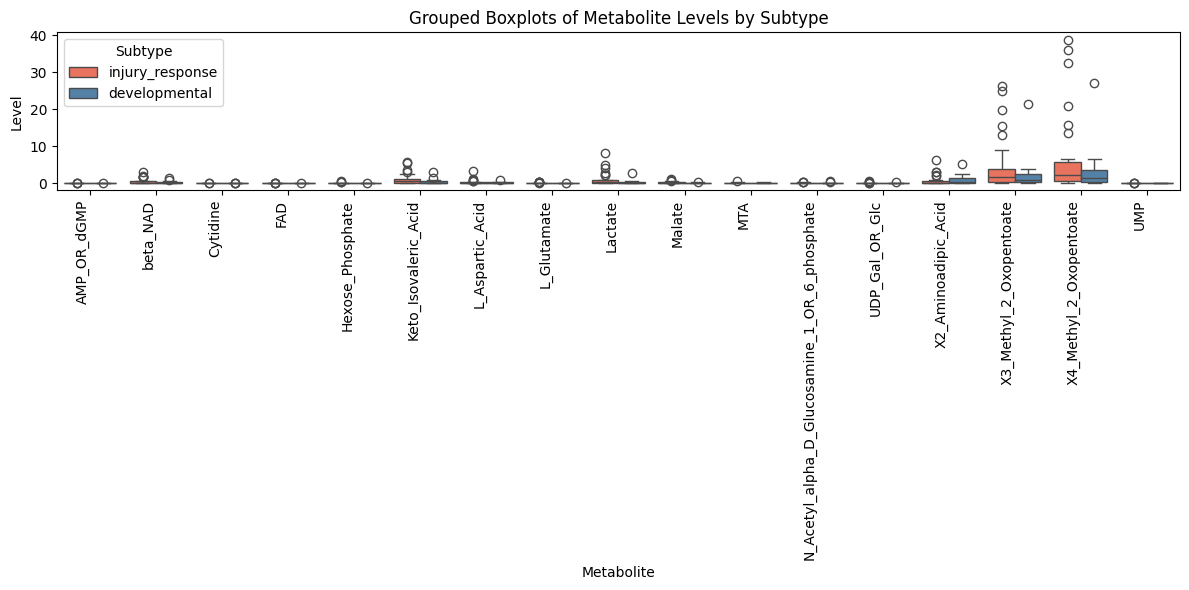

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Step 1: Convert to long format
df_long = merged_df.melt(
    id_vars='subtype',       # keep the subtype column
    var_name='Metabolite',   # reactions/metabolites column
    value_name='Level'       # flux/measurement column
)

# Step 2: Drop NaNs for safe statistics
df_long = df_long.dropna(subset=['Level'])

# Step 3: Calculate p-values per metabolite
def mann_whitney_safe(x):
    group1 = x[x['subtype']=='developmental']['Level']
    group2 = x[x['subtype']=='injury_response']['Level']
    
    # Require at least 2 values per group
    if len(group1) >= 2 and len(group2) >= 2:
        return mannwhitneyu(group1, group2, alternative='two-sided').pvalue
    else:
        return np.nan

sig_df = df_long.groupby('Metabolite').apply(mann_whitney_safe).reset_index(name='p_value')

# Step 4: Add significance stars
def get_star(p):
    if pd.isna(p):
        return ''
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

sig_df['signif'] = sig_df['p_value'].apply(get_star)

# Step 5: Merge significance info for plotting
df_plot = df_long.merge(sig_df[['Metabolite', 'signif']], on='Metabolite', how='left')

# Step 6: Plot grouped boxplots
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_plot,
    x='Metabolite',
    y='Level',
    hue='subtype',
    palette={'developmental':'steelblue', 'injury_response':'tomato'}
)

# Add significance stars above each box
for i, metabolite in enumerate(df_plot['Metabolite'].unique()):
    y_max = df_plot[df_plot['Metabolite']==metabolite]['Level'].max()
    star = sig_df.loc[sig_df['Metabolite']==metabolite, 'signif'].values[0]
    if star:
        plt.text(i, y_max + 0.01, star, ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=90, ha='right')
plt.ylabel('Level')
plt.xlabel('Metabolite')
plt.title('Grouped Boxplots of Metabolite Levels by Subtype')
plt.legend(title='Subtype')
plt.tight_layout()
plt.show()


Metabolite: Hexose_Phosphate, p-value = 0.2481, significance: 


C:\Users\xiazh\AppData\Local\Temp\ipykernel_944\2001922126.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_meta, x='subtype', y='Level', palette={'developmental':'steelblue','injury_response':'tomato'})


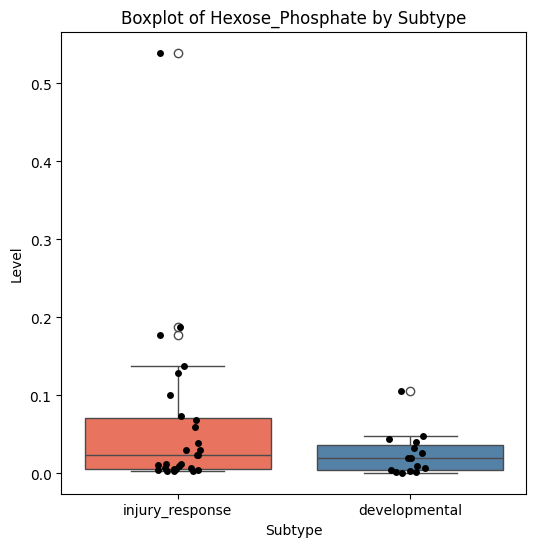

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Example: select one metabolite
metabolite_name = "Hexose_Phosphate"
df_meta = df_long[df_long['Metabolite'] == metabolite_name]

# Step 1: Calculate significance
group1 = df_meta[df_meta['subtype'] == 'developmental']['Level']
group2 = df_meta[df_meta['subtype'] == 'injury_response']['Level']

# Mann-Whitney U test
p_value = mannwhitneyu(group1, group2, alternative='two-sided').pvalue

# Optional: convert p-value to significance stars
def get_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

star = get_star(p_value)

print(f"Metabolite: {metabolite_name}, p-value = {p_value:.4f}, significance: {star}")

# Step 2: Create boxplot
plt.figure(figsize=(6,6))
sns.boxplot(data=df_meta, x='subtype', y='Level', palette={'developmental':'steelblue','injury_response':'tomato'})
sns.stripplot(data=df_meta, x='subtype', y='Level', color='black', size=5, jitter=True)  # optional: show individual points

# Add significance text above boxes
y_max = df_meta['Level'].max()
plt.text(0.5, y_max + 0.01, star, ha='center', va='bottom', fontsize=14)

plt.title(f'Boxplot of {metabolite_name} by Subtype')
plt.ylabel('Level')
plt.xlabel('Subtype')
plt.show()


Data above were normalized by dividing the metabolite level of each sample by the totalRNA level of that sample. What might be better may be to calculate the median RNA level and median metabolite level for each cell line and then dividing the median metabolite level by the median RNA level for each cell line. RNA level may be a good proxy for cell number but metabolite levels may not be so sensitive to rna level changes. 

First, I will plot the correlation between RNA level and metabolite levels. As shown below, the relationship between rna level and metabolite is not linear. 

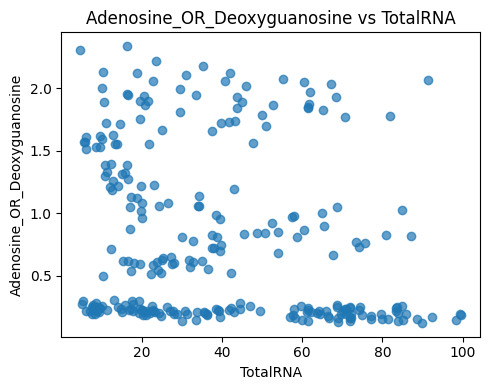

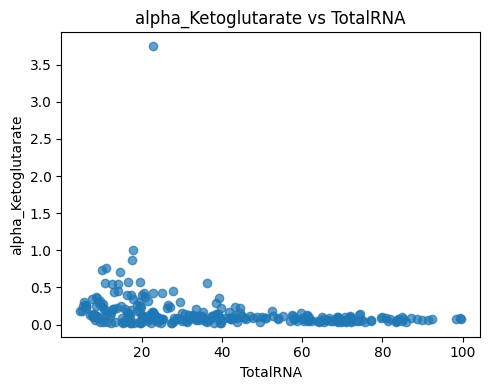

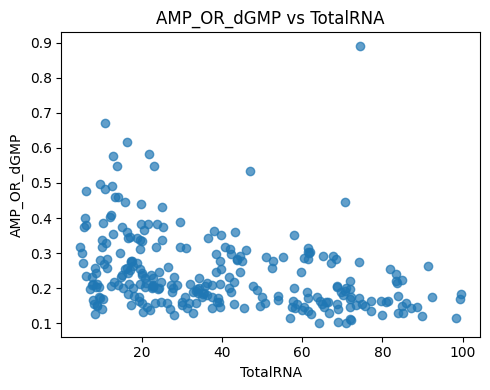

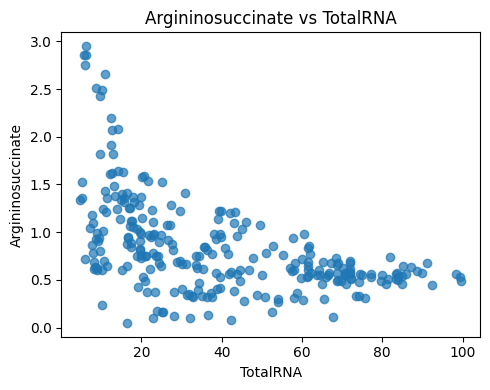

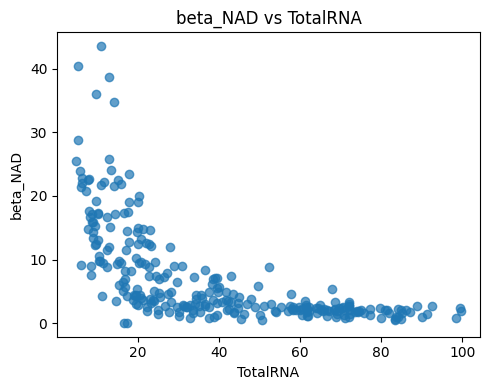

In [152]:
metabolomics_df.head()
metabolomics_df_rna = metabolomics_df[metabolomics_df['TotalRNA'].notna()]
metabolomics_df_rna.head()

import matplotlib.pyplot as plt

metabolite_start = 'Adenosine_OR_Deoxyguanosine'
metabolite_columns = metabolomics_df_rna.columns[
    metabolomics_df_rna.columns.get_loc(metabolite_start):
]

for col in metabolite_columns[0:5]:
    plt.figure(figsize=(5,4))
    plt.scatter(metabolomics_df_rna['TotalRNA'], metabolomics_df_rna[col], alpha=0.7)
    plt.xlabel('TotalRNA')
    plt.ylabel(col)
    plt.title(f'{col} vs TotalRNA')
    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(len(included_rownums)):
    keys_with_current_rownum = [key for key, count in row_counts.items() if count == included_rownums[i]]
    for j in range(len(keys_with_current_rownum)):
        current_experiment = dfs_dict[keys_with_current_rownum[j]]
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Normalize the 'Cells' dataframe to TotalRNA
        start_col = 'Adenosine_OR_Deoxyguanosine'

        # Get the subseted dataframe containing only the 'Coating' samples and get the median of each metabolite column
        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        coating_cols = sampletype_dfs['Coating'].columns[
            sampletype_dfs['Coating'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of these columns
        coating_median = sampletype_dfs['Coating'][coating_cols].median()

        # Subtract the coating_median from each corresponding column in sampletype_dfs['Cells']
        cells_df = sampletype_dfs['Cells']
        metabolite_cols = coating_median.index
        coating_subtracted = cells_df.copy()
        coating_subtracted[metabolite_cols] = cells_df[metabolite_cols] - coating_median

        # Calculate the half-min values for each metabolite column
        half_min_values = coating_subtracted[metabolite_cols].apply(lambda col: col[col > 0].min() / 2 if (col > 0).any() else np.nan)


        # Replace negative values with half-min values
        coating_subtracted_halfmin = coating_subtracted[metabolite_cols].copy()
        for col in coating_subtracted_halfmin.columns:
            coating_subtracted_halfmin.loc[coating_subtracted_halfmin[col] < 0, col] = half_min_values[col]

        # These columns only have negative values, so they will be all NaN after half-min imputation
        coating_subtracted_halfmin = coating_subtracted_halfmin.dropna(axis=1, how='all')

        coating_subtracted_normalized = coating_subtracted_halfmin.div(coating_subtracted['TotalRNA'], axis=0)
        median_values = coating_subtracted_normalized.median()
        median_rows.append(median_values)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
163,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,1.0,0.267561,0.031166,...,0.037939,0.472435,0.230827,0.704831,0.239954,7.312621,9.261954,0.000102,0.061448,4.121885
164,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,2.0,0.389552,0.043990,...,0.030166,0.194152,0.100240,1.213483,0.370319,11.247858,9.712298,0.000094,0.029010,4.096100
165,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,3.0,0.261106,0.033545,...,0.023404,0.226679,0.092935,0.699387,0.223355,9.859366,8.602156,0.000090,0.029153,4.196879
166,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,4.0,0.211518,0.029799,...,0.029781,0.208066,0.096608,0.239352,0.261994,9.185934,5.689928,0.000105,0.022313,4.170834
167,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,5.0,0.149310,0.042557,...,0.024108,0.219265,0.111523,0.280174,0.261121,9.785174,8.193086,0.000119,0.022712,4.399674
168,X20160621,NaN,1,Dirks,G523,Coating,Normoxia,6.0,0.126174,0.034243,...,0.024884,0.160767,0.077155,0.283596,0.170843,7.672585,8.656908,0.000098,0.020306,3.888903
169,X20160621,NaN,1,Dirks,G523,MediaControl,Normoxia,1.0,0.294595,0.067076,...,0.028304,0.036006,0.097526,0.395041,0.403458,12.822295,10.281107,0.000657,0.106439,7.387533
170,X20160621,NaN,1,Dirks,G523,MediaControl,Normoxia,2.0,0.282187,0.048903,...,0.030559,0.126570,0.361052,0.911564,0.407024,17.448724,36.773607,0.000747,0.214067,8.240283
171,X20160621,NaN,1,Dirks,G523,MediaControl,Normoxia,3.0,0.206038,0.115745,...,0.028734,0.054968,0.144775,0.459707,0.432076,21.208568,35.470553,0.000728,0.144201,8.544129


In [112]:
cells_median_normalized = []
cellline_order = []

for i in range(len(included_rownums)):
    keys_with_current_rownum = [key for key, count in row_counts.items() if count == included_rownums[i]]
    for j in range(len(keys_with_current_rownum)):
        current_experiment = dfs_dict[keys_with_current_rownum[j]]
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        start_col = 'Adenosine_OR_Deoxyguanosine'
        metabolite_cols = sampletype_dfs['Cells'].columns[
            sampletype_dfs['Cells'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of the metabolite columns
        metabolite_median = sampletype_dfs['Cells'][metabolite_cols].median()
        coating_median = sampletype_dfs['Coating'][metabolite_cols].median()
        RNA_median = sampletype_dfs['Cells']['TotalRNA'].median()

        metabolite_median_normalized = (metabolite_median - coating_median) / RNA_median

        cells_median_normalized.append(metabolite_median_normalized)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)



In [ ]:
cells_median_normalized_df = pd.DataFrame(cells_median_normalized, index=cellline_order)

In [116]:
# Merge cells_median and gsva_results based on their rownames (index)
normalized_merged_df = cells_median_normalized_df.merge(gsva_results['subtype'], left_index=True, right_index=True, how='left')
# Remove columns containing "LikelyBiologicalUnknown_"
normalized_merged_df = normalized_merged_df.loc[:, ~normalized_merged_df.columns.str.contains("LikelyBiologicalUnknown_")]

print(normalized_merged_df.head())

      Adenosine_OR_Deoxyguanosine  alpha_Ketoglutarate  AMP_OR_dGMP  \
G566                     0.058298             0.022322     0.021875   
G583                     0.083713            -0.003403     0.026754   
G620                     0.087817             0.006628     0.033003   
G523                     0.040739             0.006649     0.004941   
G583                     0.129963             0.012832     0.010692   

      Argininosuccinate  beta_NAD   Citrate  Cytidine  Dissacharide       FAD  \
G566           0.104839  1.605746  0.079415  0.000917      0.000530  0.003635   
G583           0.092914  1.569986  0.002282  0.001768     -0.000750  0.009475   
G620           0.084141  1.275035  0.044477  0.003131     -0.000548  0.009489   
G523           0.017590  0.078828  0.008716  0.000392      0.000140  0.001046   
G583           0.038413  0.598978  0.020354  0.000468     -0.005622  0.005443   

      Fumarate  ...    Uracil   Uridine  X2_Aminoadipic_Acid      X2HG  \
G566  0.2448

C:\Users\xiazh\AppData\Local\Temp\ipykernel_944\1060512476.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sig_df = df_long.groupby('Metabolite').apply(mann_whitney_safe).reset_index(name='p_value')


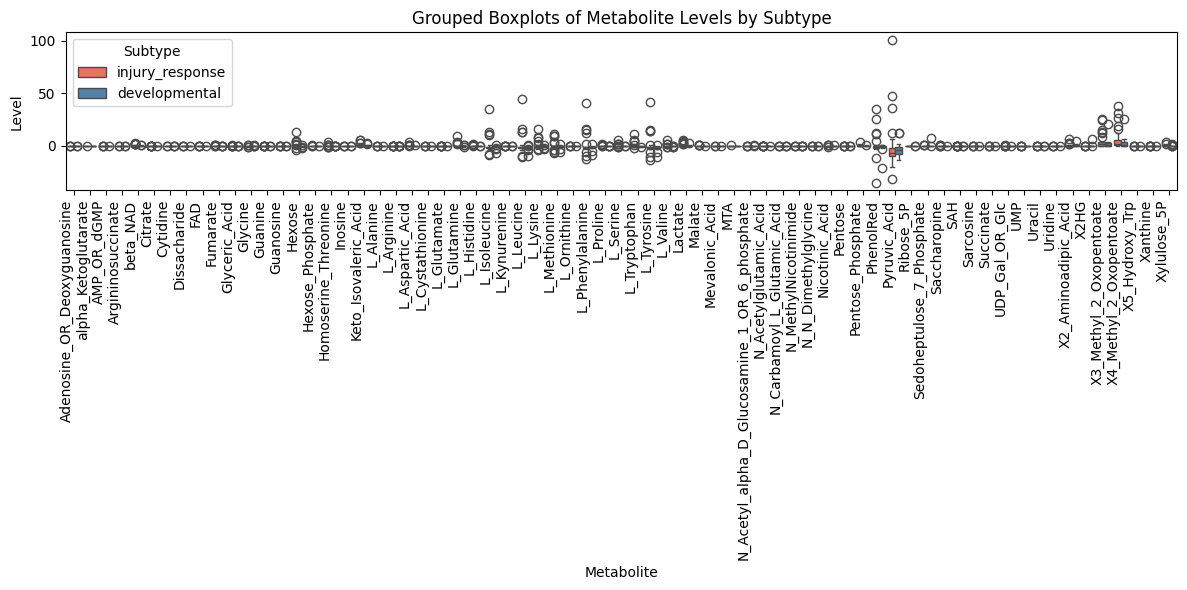

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Step 1: Convert to long format
df_long = normalized_merged_df.melt(
    id_vars='subtype',       # keep the subtype column
    var_name='Metabolite',   # reactions/metabolites column
    value_name='Level'       # flux/measurement column
)

# Step 2: Drop NaNs for safe statistics
df_long = df_long.dropna(subset=['Level'])

# Step 3: Calculate p-values per metabolite
def mann_whitney_safe(x):
    group1 = x[x['subtype']=='developmental']['Level']
    group2 = x[x['subtype']=='injury_response']['Level']
    
    # Require at least 2 values per group
    if len(group1) >= 2 and len(group2) >= 2:
        return mannwhitneyu(group1, group2, alternative='two-sided').pvalue
    else:
        return np.nan

sig_df = df_long.groupby('Metabolite').apply(mann_whitney_safe).reset_index(name='p_value')

# Step 4: Add significance stars
def get_star(p):
    if pd.isna(p):
        return ''
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

sig_df['signif'] = sig_df['p_value'].apply(get_star)

# Step 5: Merge significance info for plotting
df_plot = df_long.merge(sig_df[['Metabolite', 'signif']], on='Metabolite', how='left')

# Step 6: Plot grouped boxplots
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_plot,
    x='Metabolite',
    y='Level',
    hue='subtype',
    palette={'developmental':'steelblue', 'injury_response':'tomato'}
)

# Add significance stars above each box
for i, metabolite in enumerate(df_plot['Metabolite'].unique()):
    y_max = df_plot[df_plot['Metabolite']==metabolite]['Level'].max()
    star = sig_df.loc[sig_df['Metabolite']==metabolite, 'signif'].values[0]
    if star:
        plt.text(i, y_max + 0.01, star, ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=90, ha='right')
plt.ylabel('Level')
plt.xlabel('Metabolite')
plt.title('Grouped Boxplots of Metabolite Levels by Subtype')
plt.legend(title='Subtype')
plt.tight_layout()
plt.show()


Metabolite: X2_Aminoadipic_Acid, p-value = 0.3185, significance: 


C:\Users\xiazh\AppData\Local\Temp\ipykernel_944\2564008140.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_meta, x='subtype', y='Level', palette={'developmental':'steelblue','injury_response':'tomato'})


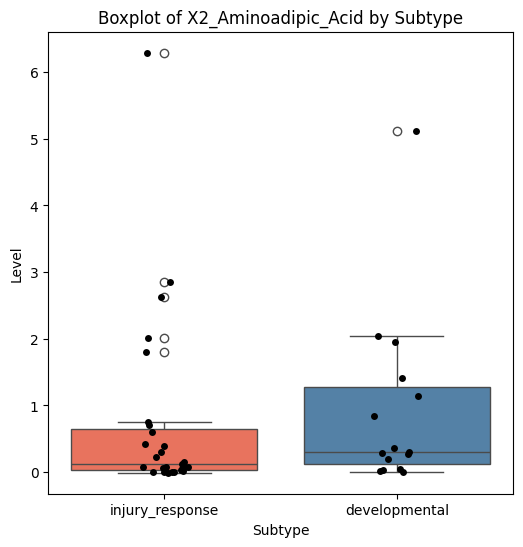

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Example: select one metabolite
# X2_Aminoadipic_Acid
# L_Kynurenine
# L_Tryptophan
metabolite_name = "X2_Aminoadipic_Acid"
df_meta = df_long[df_long['Metabolite'] == metabolite_name]

# Step 1: Calculate significance
group1 = df_meta[df_meta['subtype'] == 'developmental']['Level']
group2 = df_meta[df_meta['subtype'] == 'injury_response']['Level']

# Mann-Whitney U test
p_value = mannwhitneyu(group1, group2, alternative='two-sided').pvalue

# Optional: convert p-value to significance stars
def get_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

star = get_star(p_value)

print(f"Metabolite: {metabolite_name}, p-value = {p_value:.4f}, significance: {star}")

# Step 2: Create boxplot
plt.figure(figsize=(6,6))
sns.boxplot(data=df_meta, x='subtype', y='Level', palette={'developmental':'steelblue','injury_response':'tomato'})
sns.stripplot(data=df_meta, x='subtype', y='Level', color='black', size=5, jitter=True)  # optional: show individual points

# Add significance text above boxes
y_max = df_meta['Level'].max()
plt.text(0.5, y_max + 0.01, star, ha='center', va='bottom', fontsize=14)

plt.title(f'Boxplot of {metabolite_name} by Subtype')
plt.ylabel('Level')
plt.xlabel('Subtype')
plt.show()


There is no significant difference in Hexose_Phosphate levels between subtypes. But could there be a correlation in flux and metabolite level? No. There is no correlation between flux and metabolite level (Hexose_Phosphate and HMR_4394)

In [132]:
flux_df = pd.read_csv("C:/research/computational_flux_analysis/GSC_flux_t_nonzero_df.csv")
flux_df = flux_df.set_index(flux_df.columns[0])


flux_df.index = flux_df.index.str.replace('_L', '', regex=False)
flux_df['HMR_4394']

Unnamed: 0
BT41    1.268365e-07
BT48    5.360774e-04
BT50    6.067937e-04
BT53    1.417220e-03
BT67    4.372173e-06
            ...     
G933    2.555650e-06
G945    1.228227e-04
G946    9.589776e-06
G957    1.068897e-05
G958    4.480466e-04
Name: HMR_4394, Length: 88, dtype: float64

In [ ]:
flux_df

merged_with_flux = merged_df.merge(flux_df, left_index=True, right_index=True, how='left')

print(merged_with_flux)

            Adenosine_OR_Deoxyguanosine  alpha_Ketoglutarate  AMP_OR_dGMP  \
Unnamed: 0                                                                  
G566                           0.062097             0.023711     0.022909   
G583                           0.090835                  NaN     0.022529   
G620                           0.088861             0.007835     0.034286   
G523                           0.049039             0.006850     0.005135   
G583                           0.098079             0.017125     0.009316   
G523                           0.018384             0.000143     0.005953   
G729                           0.024602             0.011562     0.009609   
BT50                           0.022117             0.001323     0.003997   
BT94                           0.021905             0.001062     0.003353   
G477                           0.071224             0.002406     0.009696   
G626                           0.023383             0.001843     0.003596   

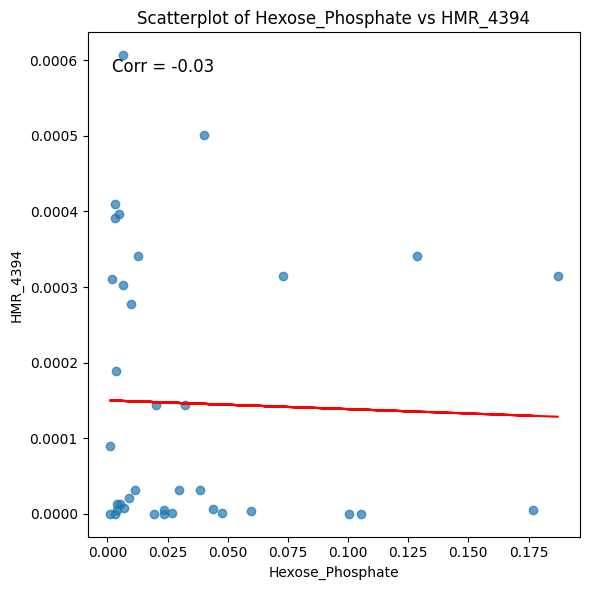

In [141]:
import matplotlib.pyplot as plt

plot_subset = merged_with_flux[['Hexose_Phosphate', 'HMR_4394']].dropna()
plot_subset = plot_subset[plot_subset['Hexose_Phosphate'] != plot_subset['Hexose_Phosphate'].max()]

plt.figure(figsize=(6,6))
plt.scatter(plot_subset['Hexose_Phosphate'], plot_subset['HMR_4394'], alpha=0.7)
plt.xlabel('Hexose_Phosphate')
plt.ylabel('HMR_4394')
plt.title('Scatterplot of Hexose_Phosphate vs HMR_4394')
plt.tight_layout()

# Plot line of best fit
m, b = np.polyfit(plot_subset['Hexose_Phosphate'], plot_subset['HMR_4394'], 1)
plt.plot(plot_subset['Hexose_Phosphate'], m * plot_subset['Hexose_Phosphate'] + b, color='red')

# Calculate correlation coefficient
corr = np.corrcoef(plot_subset['Hexose_Phosphate'], plot_subset['HMR_4394'])[0, 1]
plt.text(0.05, 0.95, f'Corr = {corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

Notes from how Olga processed the data:
1. I did not do any further normalization using RNA since the samples were diluted for Mass spec using total RNA to normalize input. In essence, each metabolite measured is already scaled to a constant concentration of RNA measured for that sample.

2. I also didn't subtract coating, because I find subtraction adds more error than it fixes. There are fluctuations in day-to-day signal from the QToF and the instrument is tuned every day. I instead used the coating control intensity to flag metabolites if they appear at  the same level in coating as cell extracts.  

3. I think all I did was take the Met/Ref intensity ratio and compare across conditions and I believe I used ANOVA/tukey-hsd test in R to get significance, but I am not sure. 

Try the analysis again below without normalizing
- Only "LikelyBiologicalUnknown_" is significantly different between subtypes, most are still insignificant --> Maybe I need to include more cell lines?


In [239]:
median_rows = []
cellline_order = []

included_rownums = [24, 23, 34, 22, 21]


for i in range(len(included_rownums)):
    keys_with_current_rownum = [key for key, count in row_counts.items() if count == included_rownums[i]]
    for j in range(len(keys_with_current_rownum)):
        current_experiment = dfs_dict[keys_with_current_rownum[j]]
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Normalize the 'Cells' dataframe to TotalRNA
        start_col = 'Adenosine_OR_Deoxyguanosine'

        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        metabolite_columns = sampletype_dfs['Cells'].columns[
            sampletype_dfs['Cells'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of these columns
        metabolite_median = sampletype_dfs['Cells'][coating_cols].median()
        median_rows.append(metabolite_median)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)


In [240]:
metabolite_median_df = pd.DataFrame(median_rows, index=cellline_order)
metabolite_median_df

# Merge cells_median and gsva_results based on their rownames (index)
metabolite_median_gsva_merged = metabolite_median_df.merge(gsva_results['subtype'], left_index=True, right_index=True, how='left')

In [241]:
metabolite_median_gsva_merged['subtype'].value_counts()

subtype
injury_response    27
developmental      15
Name: count, dtype: int64

In [242]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load your dataframe (replace with your actual CSV or Excel file)
# df = pd.read_csv("your_file.csv")  
# or df = pd.read_excel("your_file.xlsx")

# Set first column as index if it's sample IDs
df = metabolite_median_gsva_merged.set_index(metabolite_median_gsva_merged.columns[0])

# Separate groups
developmental = df[df['subtype'] == 'developmental']
injury_response = df[df['subtype'] == 'injury_response']

# Prepare result storage
results = []

# Loop through metabolites (exclude 'subtype' column)
for metabolite in df.columns.drop('subtype'):
    # Means (or medians if you prefer)
    mean_dev = developmental[metabolite].mean()
    mean_injury = injury_response[metabolite].mean()
    
    # Fold change (injury_response / developmental)
    fc = mean_injury / mean_dev if mean_dev != 0 else np.nan
    log2_fc = np.log2(fc) if fc > 0 else np.nan
    
    # Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(
        injury_response[metabolite],
        developmental[metabolite],
        alternative='two-sided'
    )
    
    results.append({
        'metabolite': metabolite,
        'mean_developmental': mean_dev,
        'mean_injury_response': mean_injury,
        'fold_change': fc,
        'log2_FC': log2_fc,
        'p_value': p_val
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# FDR correction
results_df['FDR'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Sort by significance
results_df = results_df.sort_values('p_value')

# Optional: filter significant metabolites (less stringent)
significant = results_df[(abs(results_df['log2_FC']) > 0.5) & (results_df['FDR'] < 0.1)]

# Output
print("All metabolites:")
print(results_df)

print("\nSignificant metabolites (|log2FC|>0.5 & FDR<0.1):")
print(significant)


All metabolites:
                     metabolite  mean_developmental  mean_injury_response  \
57  LikelyBiologicalUnknown_211         3102.766852            416.819775   
3                      beta_NAD            4.864683              8.082051   
22                  L_Glutamate            0.573819              0.974898   
16                      Inosine            0.138154              0.192379   
42        N_Acetylglutamic_Acid            0.602161              0.242539   
..                          ...                 ...                   ...   
51                    Ribose_5P            0.683244              0.622435   
62               UDP_Gal_OR_Glc            0.847977              0.779361   
53                 Saccharopine            0.589174              1.518657   
59  LikelyBiologicalUnknown_262            0.082988              0.088903   
39               Mevalonic_Acid            0.444893              0.428353   

    fold_change   log2_FC   p_value       FDR  
57     0.1

In [172]:
results_df[results_df['metabolite'] == 'Hexose_Phosphate']

,metabolite,mean_developmental,mean_injury_response,fold_change,log2_FC,p_value,FDR
14,Hexose_Phosphate,0.693799,1.13404,1.634537,0.708882,0.372125,0.82034


Try looking at correlation again, still no correlation.

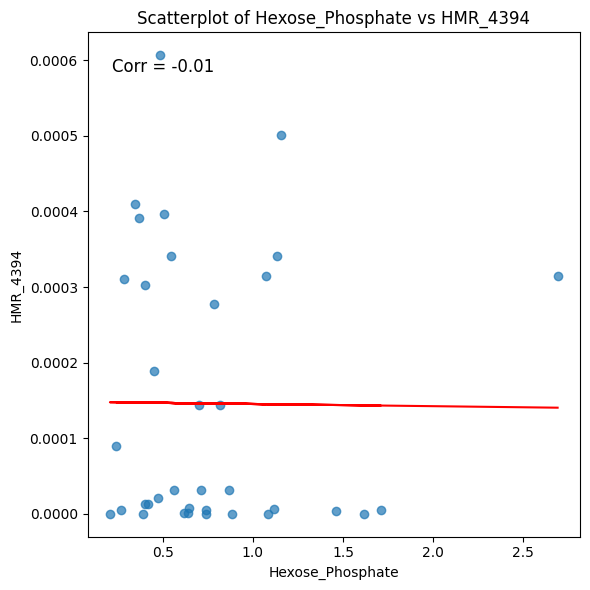

In [174]:
merged_with_flux = metabolite_median_gsva_merged.merge(flux_df, left_index=True, right_index=True, how='left')

plot_subset = merged_with_flux[['Hexose_Phosphate', 'HMR_4394']].dropna()
plot_subset = plot_subset[plot_subset['Hexose_Phosphate'] != plot_subset['Hexose_Phosphate'].max()]

plt.figure(figsize=(6,6))
plt.scatter(plot_subset['Hexose_Phosphate'], plot_subset['HMR_4394'], alpha=0.7)
plt.xlabel('Hexose_Phosphate')
plt.ylabel('HMR_4394')
plt.title('Scatterplot of Hexose_Phosphate vs HMR_4394')
plt.tight_layout()

# Plot line of best fit
m, b = np.polyfit(plot_subset['Hexose_Phosphate'], plot_subset['HMR_4394'], 1)
plt.plot(plot_subset['Hexose_Phosphate'], m * plot_subset['Hexose_Phosphate'] + b, color='red')

# Calculate correlation coefficient
corr = np.corrcoef(plot_subset['Hexose_Phosphate'], plot_subset['HMR_4394'])[0, 1]
plt.text(0.05, 0.95, f'Corr = {corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

Try including all samples in the analysis, not just from Dirks lab

In [243]:
# Import the metabolomics data
metabolomics_df = pd.read_csv('C:/research/raw_data/20200207_SU2C_All_Knowns.csv', index_col=0)
metabolomics_df.head()

# Ensure the cell line column is string type
metabolomics_df['CellLine'] = metabolomics_df['CellLine'].astype('string')

# Remove all cell lines starting with "HF" in the full dataframe, these are human fetal
metabolomics_df = metabolomics_df[~metabolomics_df['CellLine'].str.startswith('HF')]
# Remove all rows where the Oxygen column has "Hypoxia"
metabolomics_df = metabolomics_df[metabolomics_df['Oxygen'] != 'Hypoxia']


# How many unique cell lines are here? Now 34
metabolomics_df['CellLine'].nunique()

# Split the G523 large dataframe into two dataframes
# Create a dictionary of dataframes
full_dfs_dict = {key: group for key, group in metabolomics_df.groupby(['DateProcessed', 'Trial', 'Lab', 'CellLine', 'Oxygen'])}

print(list(full_dfs_dict.keys()))
print("The main df has been split into " + str(len(full_dfs_dict)) + " dataframes.")

# Example: access the dataframe for a specific combination
# subset_df = full_dfs_dict[('X20180717', np.int64(1), 'G809', 'Normoxia')]
# print(subset_df)

[('X20160316', np.int64(1), 'Dirks', 'G571', 'Normoxia'), ('X20160316', np.int64(1), 'Dirks', 'G729', 'Normoxia'), ('X20160406', np.int64(1), 'Dirks', 'G571', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G549', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G566', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G583', 'Normoxia'), ('X20160502', np.int64(1), 'Dirks', 'G620', 'Normoxia'), ('X20160621', np.int64(1), 'Dirks', 'G523', 'Normoxia'), ('X20160621', np.int64(1), 'Dirks', 'G564', 'Normoxia'), ('X20160916', np.int64(2), 'Dirks', 'G583', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G523', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G549', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G564', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G620', 'Normoxia'), ('X20161018', np.int64(2), 'Dirks', 'G729', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'BT301', 'Normoxia'), ('X20161124', np.int64(1), 'Dirks', 'BT50', 'Normoxia'), ('X20161124', np.int64(1), 'D

In [244]:
list(full_dfs_dict.keys())

dict_keys = list(full_dfs_dict.keys())
len(dict_keys)

88

In [245]:
full_dfs_dict[dict_keys[2]]

,DateProcessed,TotalRNA,Trial,Lab,CellLine,SampleType,Oxygen,Replicate,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,...,UMP,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P
FileNumber,,,,,,,,,,,,,,,,,,,,,
50,X20160406,NaN,1,Dirks,G571,Cells,Normoxia,2.0,0.261090,0.043593,...,0.016321,0.065956,0.023021,0.008588,0.111982,12.056835,5.219556,0.000126,0.017903,4.061011
51,X20160406,NaN,1,Dirks,G571,Cells,Normoxia,3.0,0.262038,0.034368,...,0.017216,0.066561,0.022893,0.007549,0.077192,12.084325,6.115708,0.000121,0.020089,4.414866
52,X20160406,NaN,1,Dirks,G571,Cells,Normoxia,4.0,0.355946,0.032897,...,0.134820,0.271817,0.086883,0.365379,0.670976,6.605629,10.025074,0.001590,0.018083,1.166622
53,X20160406,NaN,1,Dirks,G571,Cells,Normoxia,5.0,0.272029,0.038140,...,0.017731,0.070305,0.021899,0.005716,0.084223,19.477678,8.648249,0.000087,0.067563,4.347662
54,X20160406,NaN,1,Dirks,G571,Cells,Normoxia,6.0,0.421226,0.033218,...,0.150354,0.204292,0.085490,0.427077,0.228797,8.417243,8.975184,0.001535,0.019887,1.196318
55,X20160406,NaN,1,Dirks,G571,Coating,Normoxia,1.0,0.146338,0.044019,...,0.126963,0.329674,0.094728,0.408904,0.221226,8.491174,8.133864,0.000317,0.009817,1.289979
56,X20160406,NaN,1,Dirks,G571,Coating,Normoxia,2.0,0.116166,0.035147,...,0.091890,0.276373,0.096177,0.342380,0.193861,7.925853,6.861032,0.000304,0.006789,0.935707
57,X20160406,NaN,1,Dirks,G571,Coating,Normoxia,3.0,0.191130,0.025400,...,0.098302,0.295711,0.118031,0.377334,0.135434,8.265890,7.603786,0.000438,0.023556,0.851595
58,X20160406,NaN,1,Dirks,G571,Coating,Normoxia,4.0,0.131124,0.026882,...,0.113431,0.275630,0.066977,0.327809,0.146635,7.819102,6.999783,0.000383,0.004921,0.812980


In [246]:
median_rows = []
cellline_order = []

for i in range(len(dict_keys)):
    current_experiment = full_dfs_dict[dict_keys[i]]
    has_cells = (current_experiment['SampleType'] == 'Cells').any() 
    if has_cells:
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        start_col = 'Adenosine_OR_Deoxyguanosine'
        metabolite_columns = sampletype_dfs['Cells'].columns[
            sampletype_dfs['Cells'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of these columns
        metabolite_median = sampletype_dfs['Cells'][coating_cols].median()
        median_rows.append(metabolite_median)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)


In [247]:
metabolite_median_df= pd.DataFrame(median_rows, index=cellline_order)
metabolite_median_df

# Merge cells_median and gsva_results based on their rownames (index)
metabolite_median_gsva_merged = metabolite_median_df.merge(gsva_results['subtype'], left_index=True, right_index=True, how='left')

In [248]:
metabolite_median_gsva_merged['subtype'].value_counts()

subtype
injury_response    36
developmental      32
Name: count, dtype: int64

In [249]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load your dataframe (replace with your actual CSV or Excel file)
# df = pd.read_csv("your_file.csv")  
# or df = pd.read_excel("your_file.xlsx")

# Set first column as index if it's sample IDs
df = metabolite_median_gsva_merged.set_index(metabolite_median_gsva_merged.columns[0])

# Separate groups
developmental = df[df['subtype'] == 'developmental']
injury_response = df[df['subtype'] == 'injury_response']

# Prepare result storage
results = []

# Loop through metabolites (exclude 'subtype' column)
for metabolite in df.columns.drop('subtype'):
    # Means (or medians if you prefer)
    mean_dev = developmental[metabolite].mean()
    mean_injury = injury_response[metabolite].mean()
    
    # Fold change (injury_response / developmental)
    fc = mean_injury / mean_dev if mean_dev != 0 else np.nan
    log2_fc = np.log2(fc) if fc > 0 else np.nan
    
    # Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(
        injury_response[metabolite],
        developmental[metabolite],
        alternative='two-sided'
    )
    
    results.append({
        'metabolite': metabolite,
        'mean_developmental': mean_dev,
        'mean_injury_response': mean_injury,
        'fold_change': fc,
        'log2_FC': log2_fc,
        'p_value': p_val
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# FDR correction
results_df['FDR'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Sort by significance
results_df = results_df.sort_values('p_value')

# Optional: filter significant metabolites (less stringent)
significant = results_df[(abs(results_df['log2_FC']) > 0.5) & (results_df['FDR'] < 0.1)]

# Output
print("All metabolites:")
print(results_df)

print("\nSignificant metabolites (|log2FC|>0.5 & FDR<0.1):")
print(significant)


All metabolites:
                     metabolite  mean_developmental  mean_injury_response  \
42        N_Acetylglutamic_Acid            1.311534              0.298919   
57  LikelyBiologicalUnknown_211         2132.910740            371.106335   
43  N_Carbamoyl_L_Glutamic_Acid            0.104700              0.043969   
66          X2_Aminoadipic_Acid          139.835744             27.622737   
67                         X2HG            4.705226              0.321771   
..                          ...                 ...                   ...   
60  LikelyBiologicalUnknown_215            1.106270              1.212734   
6                  Dissacharide            0.060609              0.063170   
9                 Glyceric_Acid            2.397929              2.176073   
23                  L_Glutamine           17.641806             18.441137   
48            Pentose_Phosphate            9.442183             15.128410   

    fold_change   log2_FC   p_value  FDR  
42     0.227916

In [251]:
# Drop NaN p-values before FDR
valid_pvals = results_df['p_value'].dropna().values

# Apply FDR correction
reject, fdr_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh')

# Create a full FDR column aligned with results_df
results_df['FDR'] = np.nan
results_df.loc[results_df['p_value'].notna(), 'FDR'] = fdr_corrected

# Sort by p-value
results_df = results_df.sort_values('p_value')

# Filter significant
significant = results_df[
    (results_df['log2_FC'].abs() > 0.5) & 
    (results_df['FDR'] < 0.1)
]

print("All metabolites:")
print(results_df)

print("\nSignificant metabolites (|log2FC|>0.5 & FDR<0.1):")
print(significant)

# results_df.to_csv('intracellular_metabolite_stats.csv', index=False)


All metabolites:
                     metabolite  mean_developmental  mean_injury_response  \
42        N_Acetylglutamic_Acid            1.311534              0.298919   
57  LikelyBiologicalUnknown_211         2132.910740            371.106335   
43  N_Carbamoyl_L_Glutamic_Acid            0.104700              0.043969   
66          X2_Aminoadipic_Acid          139.835744             27.622737   
67                         X2HG            4.705226              0.321771   
..                          ...                 ...                   ...   
60  LikelyBiologicalUnknown_215            1.106270              1.212734   
6                  Dissacharide            0.060609              0.063170   
9                 Glyceric_Acid            2.397929              2.176073   
23                  L_Glutamine           17.641806             18.441137   
48            Pentose_Phosphate            9.442183             15.128410   

    fold_change   log2_FC   p_value       FDR  
42     0.2

Look at extracellular metabolites as well

In [214]:
secreted_median_rows = []
cellline_order = []

for i in range(len(dict_keys)):
    current_experiment = full_dfs_dict[dict_keys[i]]
    has_secreted = (current_experiment['SampleType'] == 'Secreted').any() 
    if has_secreted:
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        start_col = 'Adenosine_OR_Deoxyguanosine'
        metabolite_columns = sampletype_dfs['Secreted'].columns[
            sampletype_dfs['Secreted'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of these columns
        metabolite_median = sampletype_dfs['Secreted'][coating_cols].median()
        secreted_median_rows.append(metabolite_median)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)

secreted_metabolite_median_df= pd.DataFrame(secreted_median_rows, index=cellline_order)
secreted_metabolite_median_df

# Merge cells_median and gsva_results based on their rownames (index)
metabolite_median_gsva_merged = secreted_metabolite_median_df.merge(gsva_results['subtype'], left_index=True, right_index=True, how='left')

In [215]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load your dataframe (replace with your actual CSV or Excel file)
# df = pd.read_csv("your_file.csv")  
# or df = pd.read_excel("your_file.xlsx")

# Set first column as index if it's sample IDs
df = metabolite_median_gsva_merged.set_index(metabolite_median_gsva_merged.columns[0])

# Separate groups
developmental = df[df['subtype'] == 'developmental']
injury_response = df[df['subtype'] == 'injury_response']

# Prepare result storage
results = []

# Loop through metabolites (exclude 'subtype' column)
for metabolite in df.columns.drop('subtype'):
    # Means (or medians if you prefer)
    mean_dev = developmental[metabolite].mean()
    mean_injury = injury_response[metabolite].mean()
    
    # Fold change (injury_response / developmental)
    fc = mean_injury / mean_dev if mean_dev != 0 else np.nan
    log2_fc = np.log2(fc) if fc > 0 else np.nan
    
    # Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(
        injury_response[metabolite],
        developmental[metabolite],
        alternative='two-sided'
    )
    
    results.append({
        'metabolite': metabolite,
        'mean_developmental': mean_dev,
        'mean_injury_response': mean_injury,
        'fold_change': fc,
        'log2_FC': log2_fc,
        'p_value': p_val
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# FDR correction
results_df['FDR'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Sort by significance
results_df = results_df.sort_values('p_value')

# Optional: filter significant metabolites (less stringent)
significant = results_df[(abs(results_df['log2_FC']) > 0.5) & (results_df['FDR'] < 0.1)]

# Output
print("All metabolites:")
print(results_df)

print("\nSignificant metabolites (|log2FC|>0.5 & FDR<0.1):")
print(significant)


All metabolites:
                                       metabolite  mean_developmental  \
41  N_Acetyl_alpha_D_Glucosamine_1_OR_6_phosphate            0.774742   
38                                         Malate            0.663743   
55                                      Sarcosine            2.103970   
22                                    L_Glutamate            0.051147   
71                                       Xanthine            1.012972   
..                                            ...                 ...   
44                           N_MethylNicotinimide            1.086214   
52                      Sedoheptulose_7_Phosphate            1.494984   
66                            X2_Aminoadipic_Acid            9.345633   
48                              Pentose_Phosphate            9.798277   
61                  LikelyBiologicalUnknown_18972                 inf   

    mean_injury_response  fold_change   log2_FC       p_value  FDR  
41              2.138864     2.760744

In [216]:
# Drop NaN p-values before FDR
valid_pvals = results_df['p_value'].dropna().values

# Apply FDR correction
reject, fdr_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh')

# Create a full FDR column aligned with results_df
results_df['FDR'] = np.nan
results_df.loc[results_df['p_value'].notna(), 'FDR'] = fdr_corrected

# Sort by p-value
results_df = results_df.sort_values('p_value')

# Filter significant
significant = results_df[
    (results_df['log2_FC'].abs() > 0.5) & 
    (results_df['FDR'] < 0.1)
]

print("All metabolites:")
print(results_df)

print("\nSignificant metabolites (|log2FC|>0.5 & FDR<0.1):")
print(significant)


All metabolites:
                                       metabolite  mean_developmental  \
41  N_Acetyl_alpha_D_Glucosamine_1_OR_6_phosphate            0.774742   
38                                         Malate            0.663743   
55                                      Sarcosine            2.103970   
22                                    L_Glutamate            0.051147   
71                                       Xanthine            1.012972   
..                                            ...                 ...   
44                           N_MethylNicotinimide            1.086214   
52                      Sedoheptulose_7_Phosphate            1.494984   
66                            X2_Aminoadipic_Acid            9.345633   
48                              Pentose_Phosphate            9.798277   
61                  LikelyBiologicalUnknown_18972                 inf   

    mean_injury_response  fold_change   log2_FC       p_value       FDR  
41              2.138864     2.7

In [218]:
results_df.to_csv('extracellular_metabolite_stats.csv', index=False)

Perform the same analysis for secreted metabolites but this time subtract out the media control

In [223]:
secreted_median_rows = []
cellline_order = []

for i in range(len(dict_keys)):
    current_experiment = full_dfs_dict[dict_keys[i]]
    has_secreted = (current_experiment['SampleType'] == 'Secreted').any() 
    has_media_control = (current_experiment['SampleType'] == 'MediaControl').any()
    if has_secreted and has_media_control:
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        start_col = 'Adenosine_OR_Deoxyguanosine'
        metabolite_columns = sampletype_dfs['Secreted'].columns[
            sampletype_dfs['Secreted'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of these columns
        media_median = sampletype_dfs['MediaControl'][coating_cols].median()
        metabolite_median = sampletype_dfs['Secreted'][coating_cols].median()
        metabolite_median = metabolite_median - media_median
        secreted_median_rows.append(metabolite_median)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)

secreted_metabolite_median_normalized_df= pd.DataFrame(secreted_median_rows, index=cellline_order)
secreted_metabolite_median_normalized_df

# Merge cells_median and gsva_results based on their rownames (index)
secreted_median_gsva_merged = secreted_metabolite_median_normalized_df.merge(gsva_results['subtype'], left_index=True, right_index=True, how='left')

In [ ]:
secreted_median_gsva_merged['L_Glutamate']

G729    -0.451490
G571     0.615348
G549    -0.054965
G566    -0.448454
G583    -0.421634
           ...   
BT140   -0.001279
BT208    0.330998
BT426   -0.409488
BT429   -0.496779
BT67    -0.369168
Name: L_Glutamate, Length: 70, dtype: float64

In [224]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load your dataframe (replace with your actual CSV or Excel file)
# df = pd.read_csv("your_file.csv")  
# or df = pd.read_excel("your_file.xlsx")

# Set first column as index if it's sample IDs
df = secreted_median_gsva_merged.set_index(secreted_median_gsva_merged.columns[0])

# Separate groups
developmental = df[df['subtype'] == 'developmental']
injury_response = df[df['subtype'] == 'injury_response']

# Prepare result storage
results = []

# Loop through metabolites (exclude 'subtype' column)
for metabolite in df.columns.drop('subtype'):
    # Means
    mean_dev = developmental[metabolite].mean()
    mean_injury = injury_response[metabolite].mean()
    
    # Fold change
    fc = mean_injury / mean_dev if mean_dev != 0 else np.nan
    log2_fc = np.log2(fc) if fc > 0 else np.nan
    
    # Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(
        injury_response[metabolite],
        developmental[metabolite],
        alternative='two-sided'
    )
    
    results.append({
        'metabolite': metabolite,
        'mean_developmental': mean_dev,
        'mean_injury_response': mean_injury,
        'fold_change': fc,
        'log2_FC': log2_fc,
        'p_value': p_val
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# --- FDR correction handling NaNs ---
valid_pvals = results_df['p_value'].dropna().values
reject, fdr_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh')
results_df['FDR'] = np.nan
results_df.loc[results_df['p_value'].notna(), 'FDR'] = fdr_corrected

# Sort by p-value
results_df = results_df.sort_values('p_value')

# Filter significant metabolites
significant = results_df[
    (results_df['log2_FC'].abs() > 0.5) & 
    (results_df['FDR'] < 0.1)
]

# Output
print("All metabolites:")
print(results_df)

print("\nSignificant metabolites (|log2FC|>0.5 & FDR<0.1):")
print(significant)


All metabolites:
                                       metabolite  mean_developmental  \
41  N_Acetyl_alpha_D_Glucosamine_1_OR_6_phosphate            0.213410   
38                                         Malate            0.509236   
71                                       Xanthine            0.953191   
55                                      Sarcosine            1.300734   
12                                      Guanosine            0.596140   
..                                            ...                 ...   
47                                        Pentose           -0.107946   
29                                   L_Methionine           -4.250779   
53                                   Saccharopine            0.035458   
48                              Pentose_Phosphate           -1.945797   
61                  LikelyBiologicalUnknown_18972                 inf   

    mean_injury_response  fold_change   log2_FC       p_value       FDR  
41              1.571801     7.3

In [232]:
results_df.to_csv('secreted_minus_media.csv')

In [233]:
secreted_median_gsva_merged.to_csv("secreted_normalized.csv")

Try normalizing by dividing the secreted metabolite median by the media control median for each cell line.

This seems to be the way that Olga did it too. It makes most sense to do this because we care more about proportional changes rather than absolute changes. Normalization by division emphasesizes proportional changes whereas normalization by subtraction emphasizes absolute changes.

In [252]:
secreted_median_rows = []
cellline_order = []

for i in range(len(dict_keys)):
    current_experiment = full_dfs_dict[dict_keys[i]]
    has_secreted = (current_experiment['SampleType'] == 'Secreted').any() 
    has_media_control = (current_experiment['SampleType'] == 'MediaControl').any()
    if has_secreted and has_media_control:
        sampletype_dfs = {sample_type: group for sample_type, group in current_experiment.groupby('SampleType')}

        # Get all columns starting from 'Adenosine_OR_Deoxyguanosine' onwards
        start_col = 'Adenosine_OR_Deoxyguanosine'
        metabolite_columns = sampletype_dfs['Secreted'].columns[
            sampletype_dfs['Secreted'].columns.get_loc(start_col):
        ]

        # Calculate the median for each of these columns
        media_median = sampletype_dfs['MediaControl'][coating_cols].median()
        metabolite_median = sampletype_dfs['Secreted'][coating_cols].median()
        metabolite_median = metabolite_median / media_median
        secreted_median_rows.append(metabolite_median)
        current_cellline = current_experiment['CellLine'].iloc[0]
        cellline_order.append(current_cellline)

secreted_metabolite_median_normalized_df= pd.DataFrame(secreted_median_rows, index=cellline_order)
secreted_metabolite_median_normalized_df

# Merge cells_median and gsva_results based on their rownames (index)
secreted_median_gsva_merged = secreted_metabolite_median_normalized_df.merge(gsva_results['subtype'], left_index=True, right_index=True, how='left')

In [256]:
secreted_median_gsva_merged

,Adenosine_OR_Deoxyguanosine,alpha_Ketoglutarate,AMP_OR_dGMP,Argininosuccinate,beta_NAD,Citrate,Cytidine,Dissacharide,FAD,Fumarate,...,Uracil,Uridine,X2_Aminoadipic_Acid,X2HG,X3_Methyl_2_Oxopentoate,X4_Methyl_2_Oxopentoate,X5_Hydroxy_Trp,Xanthine,Xylulose_5P,subtype
G729,3.266341,4.790371,1.064193,1.750251,1.156321,1.592576,1.106721,0.948810,7.426177,1.130733,...,1.323045,19.660131,41.934296,1.435195,581.060227,1398.121828,1.072419,60.290770,0.986146,injury_response
G571,3.086119,5.832417,0.581864,1.826312,3.565822,2.474250,2.120746,0.994783,1.458322,0.917644,...,2.517805,66.665781,18.325584,1.445374,430.410062,414.439807,0.993450,57.486896,1.322751,injury_response
G549,3.160254,14.883623,0.922497,2.991994,1.534985,1.672056,7.472208,1.231496,0.000000,1.058498,...,2.404951,22.426406,24.576385,1.851529,2025.544440,1259.760278,0.736638,54.418173,1.542340,injury_response
G566,1.868984,4.958731,0.936829,2.284619,2.628167,2.798224,1.717936,1.048233,0.872980,1.251257,...,3.634960,11.430681,34.976310,2.869116,934.295749,1477.170969,1.108557,23.713584,1.330290,injury_response
G583,2.094250,2.031606,1.103449,1.477432,2.620208,2.288204,2.615276,0.991794,1.310061,0.731848,...,4.605664,26.774346,8.789741,1.155581,511.617503,1011.954403,0.904100,42.588786,1.435135,injury_response
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BT140,1.101682,0.958525,1.087595,1.010844,1.118527,1.098839,1.177209,0.968615,1.198186,0.919504,...,1.164502,0.935668,0.921008,0.842345,1.044296,1.013641,1.194818,1.108392,0.909970,developmental
BT208,1.842528,1.180148,1.083425,1.241903,0.930694,11.234334,1.509729,1.011847,0.751400,1.088030,...,1.316590,3.134067,5.633890,1.748067,91.040215,82.645392,1.043022,19.650241,0.770329,injury_response
BT426,1.443760,0.997314,1.045398,0.987255,1.387901,1.092222,2.392262,0.885482,0.955829,0.880028,...,1.240489,7.442487,1.950058,0.891575,85.366991,62.432871,0.975527,2.024242,0.777288,developmental
BT429,1.233680,0.916612,1.019208,1.061376,1.311787,0.894067,1.400048,0.909661,1.251209,1.101886,...,1.133504,6.530444,3.115973,1.587315,94.498583,93.509153,0.983753,1.106693,0.980239,developmental


In [253]:
secreted_median_gsva_merged['subtype'].value_counts()

subtype
injury_response    33
developmental      32
Name: count, dtype: int64

In [254]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load your dataframe (replace with your actual CSV or Excel file)
# df = pd.read_csv("your_file.csv")  
# or df = pd.read_excel("your_file.xlsx")

# Set first column as index if it's sample IDs
df = secreted_median_gsva_merged.set_index(secreted_median_gsva_merged.columns[0])

# Separate groups
developmental = df[df['subtype'] == 'developmental']
injury_response = df[df['subtype'] == 'injury_response']

# Prepare result storage
results = []

# Loop through metabolites (exclude 'subtype' column)
for metabolite in df.columns.drop('subtype'):
    # Means
    mean_dev = developmental[metabolite].mean()
    mean_injury = injury_response[metabolite].mean()
    
    # Fold change
    fc = mean_injury / mean_dev if mean_dev != 0 else np.nan
    log2_fc = np.log2(fc) if fc > 0 else np.nan
    
    # Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(
        injury_response[metabolite],
        developmental[metabolite],
        alternative='two-sided'
    )
    
    results.append({
        'metabolite': metabolite,
        'mean_developmental': mean_dev,
        'mean_injury_response': mean_injury,
        'fold_change': fc,
        'log2_FC': log2_fc,
        'p_value': p_val
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# --- FDR correction handling NaNs ---
valid_pvals = results_df['p_value'].dropna().values
reject, fdr_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh')
results_df['FDR'] = np.nan
results_df.loc[results_df['p_value'].notna(), 'FDR'] = fdr_corrected

# Sort by p-value
results_df = results_df.sort_values('p_value')

# Filter significant metabolites
significant = results_df[
    (results_df['log2_FC'].abs() > 0.5) & 
    (results_df['FDR'] < 0.1)
]

# Output
print("All metabolites:")
print(results_df)

print("\nSignificant metabolites (|log2FC|>0.5 & FDR<0.1):")
print(significant)


All metabolites:
                                       metabolite  mean_developmental  \
41  N_Acetyl_alpha_D_Glucosamine_1_OR_6_phosphate            1.395676   
71                                       Xanthine           12.123529   
14                               Hexose_Phosphate            1.311875   
38                                         Malate            7.152488   
22                                    L_Glutamate            0.135613   
..                                            ...                 ...   
3                                        beta_NAD            1.887559   
7                                             FAD                 inf   
48                              Pentose_Phosphate            0.930954   
61                  LikelyBiologicalUnknown_18972                 inf   
62                                 UDP_Gal_OR_Glc            5.904964   

    mean_injury_response  fold_change   log2_FC       p_value       FDR  
41              3.890369     2.7

In [272]:
sig_metabolites = significant['metabolite'].to_list()
print(sig_metabolites)

['N_Acetyl_alpha_D_Glucosamine_1_OR_6_phosphate', 'Xanthine', 'Hexose_Phosphate', 'Malate', 'L_Glutamate', 'Citrate', 'Sarcosine', 'Uracil', 'Guanosine', 'LikelyBiologicalUnknown_211', 'L_Kynurenine', 'L_Aspartic_Acid', 'Succinate']


In [273]:
sig_metabolites.remove("LikelyBiologicalUnknown_211")
sig_metabolites.remove("Xanthine")
sig_metabolites.remove("Malate")

In [236]:
results_df.to_csv('secreted_division_normalized_to_media.csv')

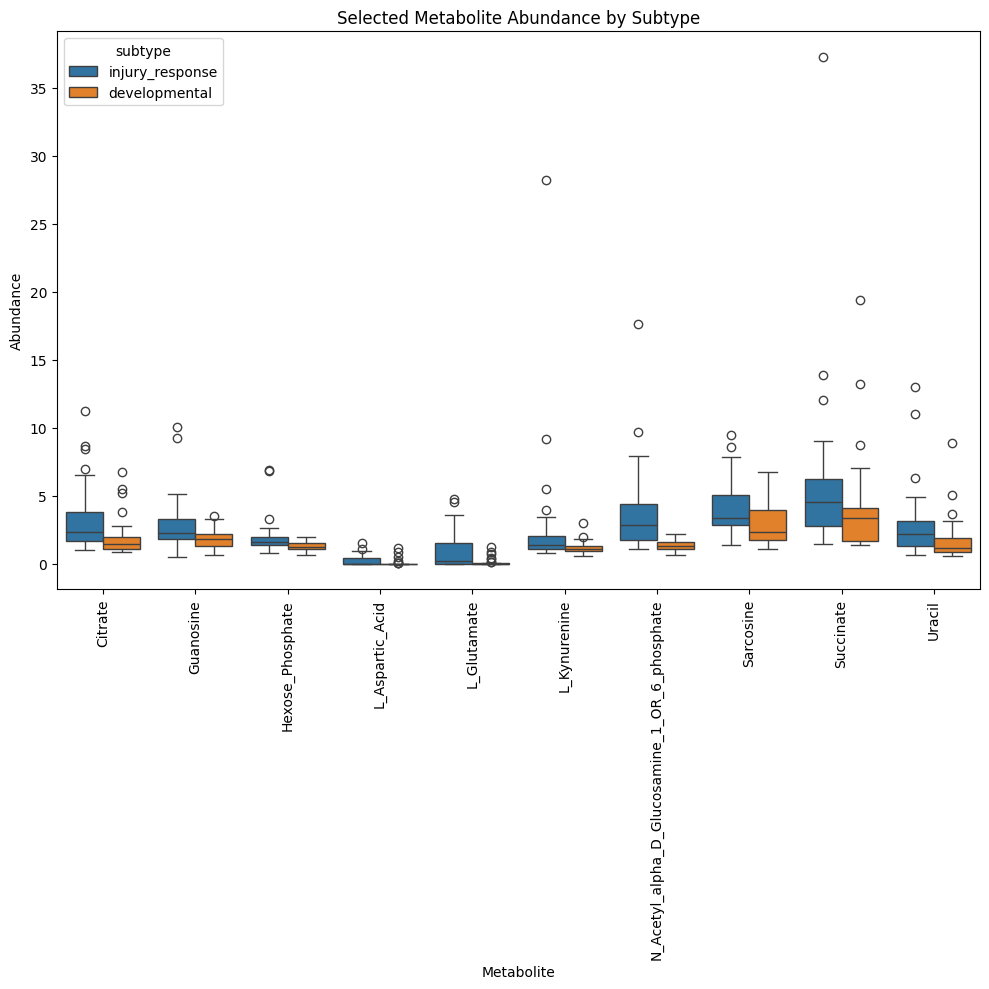

In [275]:
# Melt the dataframe to long format
df_long = secreted_median_gsva_merged.reset_index().melt(
    id_vars=['index', 'subtype'], 
    var_name='Metabolite', 
    value_name='Abundance'
)

# Optional: rename 'index' column to 'Sample'
df_long.rename(columns={'index':'Sample'}, inplace=True)

# Filter to only the metabolites in your list
df_long_filtered = df_long[df_long['Metabolite'].isin(sig_metabolites)]

# Plot boxplots
plt.figure(figsize=(10, 10))
sns.boxplot(x='Metabolite', y='Abundance', hue='subtype', data=df_long_filtered)
plt.xticks(rotation=90)
plt.title('Selected Metabolite Abundance by Subtype')
plt.tight_layout()
plt.show()

In [262]:
df_long

,Sample,subtype,Metabolite,Abundance
0,G729,injury_response,Adenosine_OR_Deoxyguanosine,3.266341
1,G571,injury_response,Adenosine_OR_Deoxyguanosine,3.086119
2,G549,injury_response,Adenosine_OR_Deoxyguanosine,3.160254
3,G566,injury_response,Adenosine_OR_Deoxyguanosine,1.868984
4,G583,injury_response,Adenosine_OR_Deoxyguanosine,2.094250
...,...,...,...,...
5175,BT140,developmental,Xylulose_5P,0.909970
5176,BT208,injury_response,Xylulose_5P,0.770329
5177,BT426,developmental,Xylulose_5P,0.777288
5178,BT429,developmental,Xylulose_5P,0.980239


Try plotting the correlation between glutamate levels and flux through relevant glutamate reactions

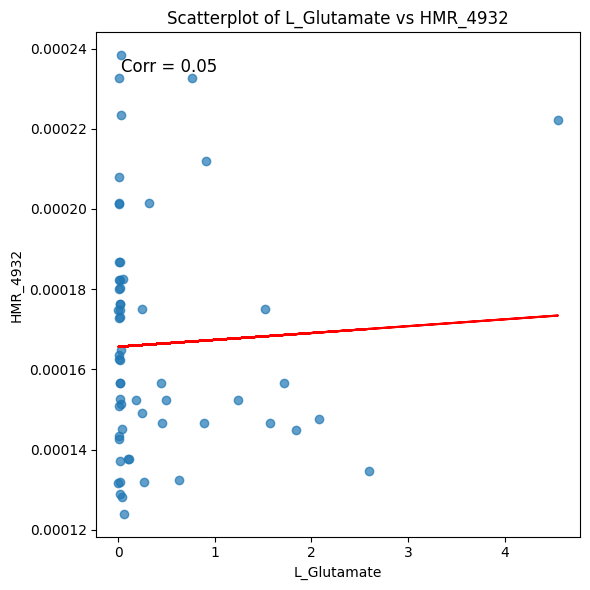

In [255]:
merged_with_flux = secreted_median_gsva_merged.merge(flux_df, left_index=True, right_index=True, how='left')

plot_subset = merged_with_flux[['L_Glutamate', 'HMR_4932']].dropna()
plot_subset = plot_subset[plot_subset['L_Glutamate'] != plot_subset['L_Glutamate'].max()]

plt.figure(figsize=(6,6))
plt.scatter(plot_subset['L_Glutamate'], plot_subset['HMR_4932'], alpha=0.7)
plt.xlabel('L_Glutamate')
plt.ylabel('HMR_4932')
plt.title('Scatterplot of L_Glutamate vs HMR_4932')
plt.tight_layout()

# Plot line of best fit
m, b = np.polyfit(plot_subset['L_Glutamate'], plot_subset['HMR_4932'], 1)
plt.plot(plot_subset['L_Glutamate'], m * plot_subset['L_Glutamate'] + b, color='red')

# Calculate correlation coefficient
corr = np.corrcoef(plot_subset['L_Glutamate'], plot_subset['HMR_4932'])[0, 1]
plt.text(0.05, 0.95, f'Corr = {corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

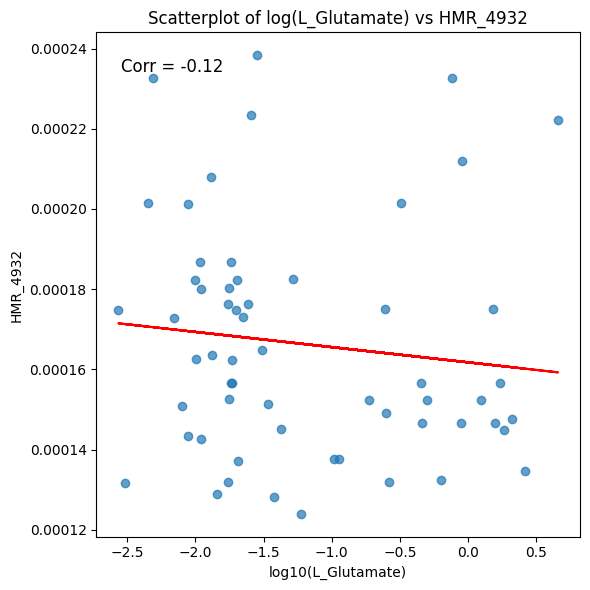

In [277]:
import numpy as np
import matplotlib.pyplot as plt

# Merge your data as before
merged_with_flux = secreted_median_gsva_merged.merge(flux_df, left_index=True, right_index=True, how='left')

# Select columns and drop NAs
plot_subset = merged_with_flux[['L_Glutamate', 'HMR_4932']].dropna()

# Optionally remove outliers
plot_subset = plot_subset[plot_subset['L_Glutamate'] != plot_subset['L_Glutamate'].max()]

# Log-transform L_Glutamate (add small constant to avoid log(0))
plot_subset['log_L_Glutamate'] = np.log10(plot_subset['L_Glutamate'] + 1e-6)

# Scatter plot with line of best fit
plt.figure(figsize=(6,6))
plt.scatter(plot_subset['log_L_Glutamate'], plot_subset['HMR_4932'], alpha=0.7)
plt.xlabel('log10(L_Glutamate)')
plt.ylabel('HMR_4932')
plt.title('Scatterplot of log(L_Glutamate) vs HMR_4932')

# Line of best fit
m, b = np.polyfit(plot_subset['log_L_Glutamate'], plot_subset['HMR_4932'], 1)
plt.plot(plot_subset['log_L_Glutamate'], m * plot_subset['log_L_Glutamate'] + b, color='red')

# Correlation coefficient
corr = np.corrcoef(plot_subset['log_L_Glutamate'], plot_subset['HMR_4932'])[0, 1]
plt.text(0.05, 0.95, f'Corr = {corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()


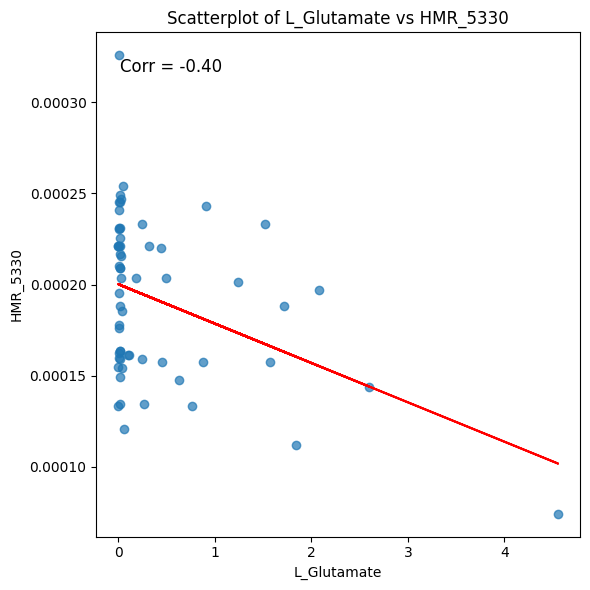

In [276]:
merged_with_flux = secreted_median_gsva_merged.merge(flux_df, left_index=True, right_index=True, how='left')

plot_subset = merged_with_flux[['L_Glutamate', 'HMR_5330']].dropna()
plot_subset = plot_subset[plot_subset['L_Glutamate'] != plot_subset['L_Glutamate'].max()]

plt.figure(figsize=(6,6))
plt.scatter(plot_subset['L_Glutamate'], plot_subset['HMR_5330'], alpha=0.7)
plt.xlabel('L_Glutamate')
plt.ylabel('HMR_5330')
plt.title('Scatterplot of L_Glutamate vs HMR_5330')
plt.tight_layout()

# Plot line of best fit
m, b = np.polyfit(plot_subset['L_Glutamate'], plot_subset['HMR_5330'], 1)
plt.plot(plot_subset['L_Glutamate'], m * plot_subset['L_Glutamate'] + b, color='red')

# Calculate correlation coefficient
corr = np.corrcoef(plot_subset['L_Glutamate'], plot_subset['HMR_5330'])[0, 1]
plt.text(0.05, 0.95, f'Corr = {corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

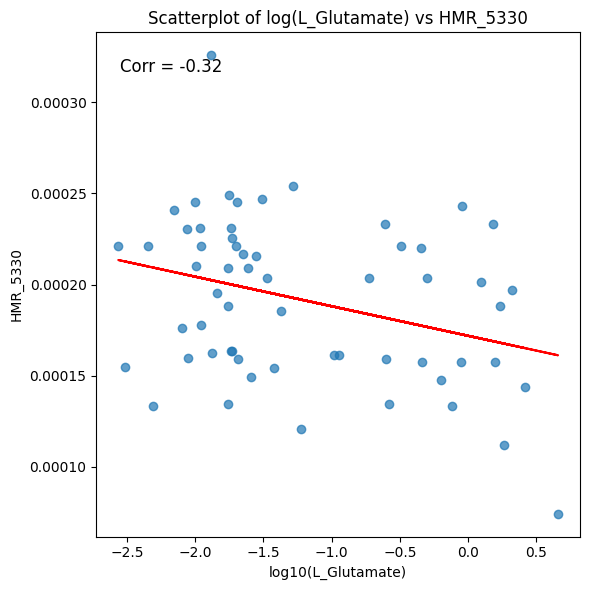

In [278]:
import numpy as np
import matplotlib.pyplot as plt

# Merge your data
merged_with_flux = secreted_median_gsva_merged.merge(flux_df, left_index=True, right_index=True, how='left')

# Select columns and drop NAs
plot_subset = merged_with_flux[['L_Glutamate', 'HMR_5330']].dropna()

# Optionally remove outliers
plot_subset = plot_subset[plot_subset['L_Glutamate'] != plot_subset['L_Glutamate'].max()]

# Log-transform L_Glutamate (add small constant to avoid log(0))
plot_subset['log_L_Glutamate'] = np.log10(plot_subset['L_Glutamate'] + 1e-6)

# Scatter plot with line of best fit
plt.figure(figsize=(6,6))
plt.scatter(plot_subset['log_L_Glutamate'], plot_subset['HMR_5330'], alpha=0.7)
plt.xlabel('log10(L_Glutamate)')
plt.ylabel('HMR_5330')
plt.title('Scatterplot of log(L_Glutamate) vs HMR_5330')

# Line of best fit
m, b = np.polyfit(plot_subset['log_L_Glutamate'], plot_subset['HMR_5330'], 1)
plt.plot(plot_subset['log_L_Glutamate'], m * plot_subset['log_L_Glutamate'] + b, color='red')

# Correlation coefficient
corr = np.corrcoef(plot_subset['log_L_Glutamate'], plot_subset['HMR_5330'])[0, 1]
plt.text(0.05, 0.95, f'Corr = {corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()


In [279]:
# Write a function to correlate any metabolite with any flux
def plot_metabolite_vs_flux(metabolite_name, flux_id):
    import numpy as np
    import matplotlib.pyplot as plt

    # Merge your data
    merged_with_flux = secreted_median_gsva_merged.merge(flux_df, left_index=True, right_index=True, how='left')

    # Select columns and drop NAs
    plot_subset = merged_with_flux[[metabolite_name, flux_id]].dropna()

    # Optionally remove outliers
    plot_subset = plot_subset[plot_subset[metabolite_name] != plot_subset[metabolite_name].max()]

    # Log-transform metabolite (add small constant to avoid log(0))
    plot_subset['log_metabolite'] = np.log10(plot_subset[metabolite_name] + 1e-6)

    # Scatter plot with line of best fit
    plt.figure(figsize=(6,6))
    plt.scatter(plot_subset['log_metabolite'], plot_subset[flux_id], alpha=0.7)
    plt.xlabel(f'log10({metabolite_name})')
    plt.ylabel(flux_id)
    plt.title(f'Scatterplot of log({metabolite_name}) vs {flux_id}')

    # Line of best fit
    m, b = np.polyfit(plot_subset['log_metabolite'], plot_subset[flux_id], 1)
    plt.plot(plot_subset['log_metabolite'], m * plot_subset['log_metabolite'] + b, color='red')

    # Correlation coefficient
    corr = np.corrcoef(plot_subset['log_metabolite'], plot_subset[flux_id])[0, 1]
    plt.text(0.05, 0.95, f'Corr = {corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

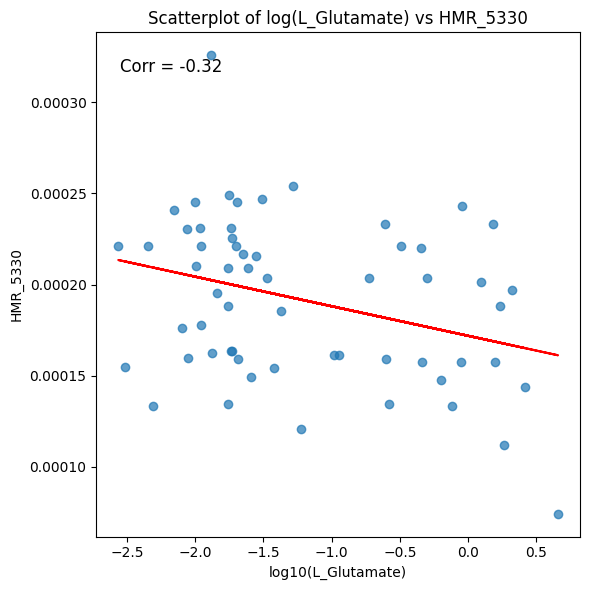

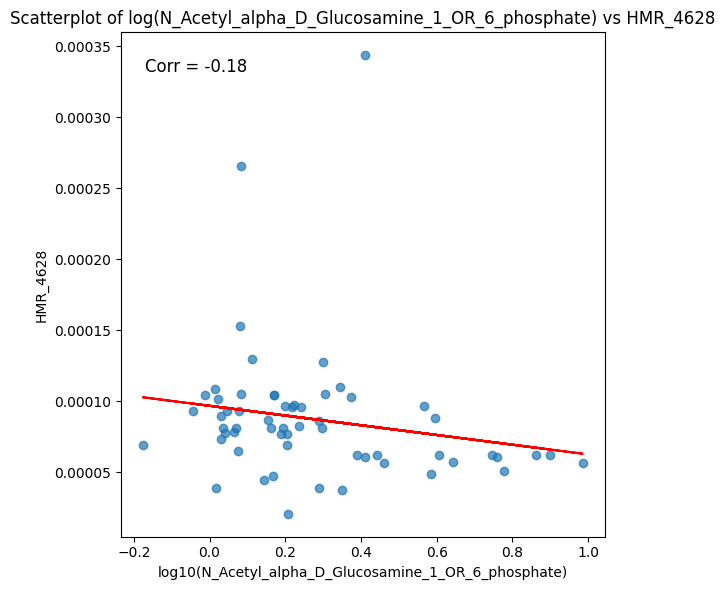

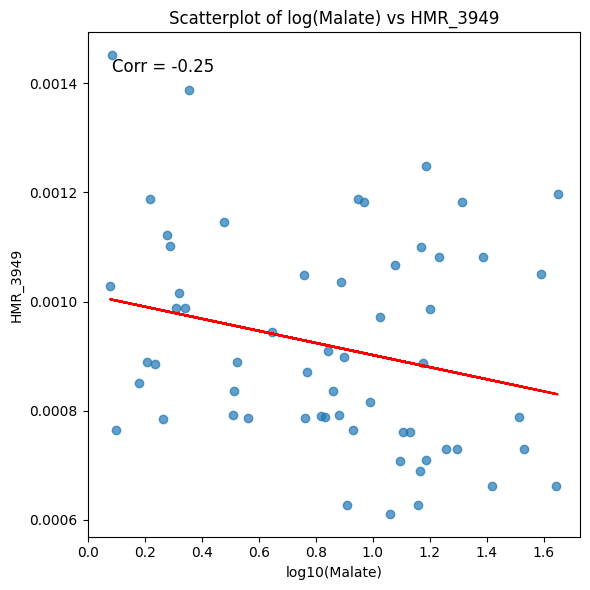

In [286]:
plot_metabolite_vs_flux('L_Glutamate', 'HMR_5330')
plot_metabolite_vs_flux('N_Acetyl_alpha_D_Glucosamine_1_OR_6_phosphate', 'HMR_4628')
plot_metabolite_vs_flux('Malate', 'HMR_3949')